In [1]:
from read_json import *
from spectrum_integrate import *
from plots import *
from source_filter import *
from variability_estimator import *

In [2]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.table import Table

In [3]:
## import

path_4lac_dr3_catalog = '../4LAC_catalog_generator_v3/resulting_catalogs/agn_pop_4lac_dr3.ecsv'
table_agn_pop_4lac_dr3 = Table.read(path_4lac_dr3_catalog, format='ascii.ecsv')
df_agn_pop_4lac_dr3 = table_agn_pop_4lac_dr3.to_pandas()

df_agn_pop_4lac_dr3.head()

,Source_Name,RAJ2000,DEJ2000,Redshift,SpectrumType,Pivot_Energy,PL_Flux_Density,PL_Index,LP_Flux_Density,LP_Index,LP_beta,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Flux1000,Unc_Flux1000
0,J0001.2+4741,0.3126,47.685902,-inf,PowerLaw,2420.575195,2.156031e-14,2.271696,2.196550e-14,2.254081,0.012156,bcu,ISP,25.313953,0.675882,0.312850,1.259796e-10,2.877197e-11
1,J0001.2-0747,0.3151,-7.797100,-inf,PowerLaw,1721.603882,2.656894e-13,2.116692,2.842831e-13,2.078927,0.051182,bll,LSP,46.780693,0.406565,0.111870,7.471219e-10,5.041939e-11
2,J0001.4-0010,0.3717,-0.169900,0.461516,PowerLaw,4307.082520,6.067356e-15,1.939160,6.488817e-15,1.661223,0.132438,bll,LSP,9.272764,0.000000,10.000000,1.082246e-10,2.914440e-11
3,J0001.5+2113,0.3815,21.218300,1.106000,LogParabola,329.773743,4.683598e-11,2.654060,5.371562e-11,2.514159,0.159319,fsrq,ISP,1910.935791,0.996138,0.213478,1.347354e-09,6.172809e-11
4,J0001.6-4156,0.4165,-41.942501,-inf,PowerLaw,4047.030029,1.881541e-14,1.775175,2.131597e-14,1.693865,0.072754,bcu,HSP,26.393343,0.490977,0.175782,2.821817e-10,3.090882e-11


In [4]:
## saving our changes in a separate dataframe

df_4lac_luana_dr3 = df_agn_pop_4lac_dr3.copy()

In [5]:
df_4lac_luana_dr3 = df_4lac_luana_dr3.drop(df_4lac_luana_dr3.columns[5:11], axis=1)
df_4lac_luana_dr3 = df_4lac_luana_dr3.drop(columns=['RAJ2000', 'DEJ2000', 'Redshift', 'Flux1000', 'Unc_Flux1000'])

In [6]:
## adding spectrum flux calculations

spectrum_flux_values = []
spectrum_flux_Flux1000comparison = []

for index, row in df_4lac_luana_dr3.iterrows():
    source_name = row['Source_Name']
    
    ## integrate from 1-100 GeV
    spectrum_flux_test, diff_flux_test, spec_type_test = integrate_spectrum_flux(source_name, df_agn_pop_4lac_dr3, 1, 100)
    spectrum_flux_Flux1000comparison.append(spectrum_flux_test)
    
    ## integrate from 0.1-100 GeV
    spectrum_flux, diff_flux, spec_type = integrate_spectrum_flux(source_name, df_agn_pop_4lac_dr3, 0.1, 100)
    spectrum_flux_values.append(spectrum_flux)

df_4lac_luana_dr3['Spectrum_Flux_Estimated'] = spectrum_flux_values

/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/spectrum_integrate.py:71: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  flux_from_spectrum = integrate.quad(lambda x: K * ((x/E_0)**(- alpha - beta * np.log(x/E_0))),


In [7]:
## getting a list of the downloaded sources

folder_path = '../4LAC_lightcurve_downloader_v3/resulting_catalogs/input_lightcurve_downloads_v3/fixed_indexed_lightcurves/3days_ts1_fixedindex_lightcurves'

## glob to get all .json files in the folder
json_files = glob.glob(os.path.join(folder_path, '*.json'))
json_file_names = [os.path.basename(file)[5:17] for file in json_files]

len(json_file_names)

1429

In [8]:
## creating a df for the downloaded sources

df_filtered_4lac_luana_dr3 = df_4lac_luana_dr3[df_4lac_luana_dr3['Source_Name'].isin(json_file_names)].copy()
df_filtered_4lac_luana_dr3.reset_index(drop=True, inplace=True)

print(len(df_filtered_4lac_luana_dr3))

1429


In [9]:
json_source_names = df_filtered_4lac_luana_dr3['Source_Name'].tolist()

len(json_source_names)

1429

In [10]:
#### open light curve files & FILTER
## Unconstrained Points become Upper Limit

## 3-days

source_names_3days = []
UL_bright_ratio_3days = []

## case zero
nExcess_3days_zero = []
unc_nExcess_3days_zero = []
fvar_3days_zero = []
unc_fvar_3days_zero = []

## case average
nExcess_3days_aver = []
unc_nExcess_3days_aver = []
fvar_3days_aver = []
unc_fvar_3days_aver = []


for source_name in json_source_names:
    file_name = f'4FGL+{source_name}.json'
    source_data = Read_json_file(file_name, '3-days', 'fixed')
    source_df = source_data.dataframe
    source_dict = source_data.dictionary
    
    filtered_df = filter_outliers(source_df)
    
    ## UL check
    bright_ratio = len(filtered_df['flux_upper_limits'].dropna()) / len(filtered_df['flux'].dropna())
    
    ## 50% cut
    if bright_ratio < 1.0:
        # print(bright_ratio)
        UL_bright_ratio_3days.append(bright_ratio)
        
        ## input Upper Limits
        
        ## case zero
        df_case_zero = input_upperL(filtered_df, 'zero')
        variability = Estimate_variability(df_case_zero)
        sigma_nxs, err_sigma_nxs, fvar, err_fvar = variability.calculate_variability()
    
        source_names_3days.append(source_name)
        
        nExcess_3days_zero.append(sigma_nxs)
        unc_nExcess_3days_zero.append(err_sigma_nxs)
        fvar_3days_zero.append(fvar)
        unc_fvar_3days_zero.append(err_fvar)
        
        ## case average
        df_case_average = input_upperL(filtered_df, 'average')
        variability_2 = Estimate_variability(df_case_average)
        sigma_nxs_2, err_sigma_nxs_2, fvar_2, err_fvar_2 = variability_2.calculate_variability()
        
        nExcess_3days_aver.append(sigma_nxs_2)
        unc_nExcess_3days_aver.append(err_sigma_nxs_2)
        fvar_3days_aver.append(fvar_2)
        unc_fvar_3days_aver.append(err_fvar_2)
    
df_variability_3days_zero = pd.DataFrame(list(zip(source_names_3days, UL_bright_ratio_3days,
                                                     nExcess_3days_zero, unc_nExcess_3days_zero,
                                                     fvar_3days_zero, unc_fvar_3days_zero)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(3_days)', 'Unc_Norm_Excess_Var(3_days)',
                                                      'Frac_Variability(3_days)', 'Unc_Frac_Variability(3_days)'])

df_variability_3days_aver = pd.DataFrame(list(zip(source_names_3days, UL_bright_ratio_3days,
                                                     nExcess_3days_aver, unc_nExcess_3days_aver,
                                                     fvar_3days_aver, unc_fvar_3days_aver)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(3_days)', 'Unc_Norm_Excess_Var(3_days)',
                                                      'Frac_Variability(3_days)', 'Unc_Frac_Variability(3_days)'])

In [11]:
df_variability_3days_zero

,Source_Name,Bright_Ratio,Norm_Excess_Var(3_days),Unc_Norm_Excess_Var(3_days),Frac_Variability(3_days),Unc_Frac_Variability(3_days)
0,J0050.7-0929,0.838824,-0.058916,0.012473,0.000000,0.100000
1,J0102.8+5824,0.847436,0.231669,0.015817,0.481320,0.016431
2,J0108.6+0134,0.130749,1.173606,0.011079,1.083331,0.005113
3,J0112.1+2245,0.218289,0.253085,0.012100,0.503076,0.012026
4,J0120.4-2701,0.802995,-0.159784,0.008598,0.000000,0.100000
...,...,...,...,...,...,...
106,J2236.5-1433,0.732673,1.227593,0.027933,1.107968,0.012605
107,J2243.9+2021,0.746417,-0.012990,0.016760,0.000000,0.100000
108,J2253.9+1609,0.049008,3.801749,0.008343,1.949807,0.002139
109,J2329.3-4955,0.775083,0.940634,0.015472,0.969863,0.007977


In [12]:
df_variability_3days_aver

,Source_Name,Bright_Ratio,Norm_Excess_Var(3_days),Unc_Norm_Excess_Var(3_days),Frac_Variability(3_days),Unc_Frac_Variability(3_days)
0,J0050.7-0929,0.838824,-0.058916,0.012473,0.000000,0.100000
1,J0102.8+5824,0.847436,0.231669,0.015817,0.481320,0.016431
2,J0108.6+0134,0.130749,1.173606,0.011079,1.083331,0.005113
3,J0112.1+2245,0.218289,0.253085,0.012100,0.503076,0.012026
4,J0120.4-2701,0.802995,-0.159784,0.008598,0.000000,0.100000
...,...,...,...,...,...,...
106,J2236.5-1433,0.732673,1.227593,0.027933,1.107968,0.012605
107,J2243.9+2021,0.746417,-0.012990,0.016760,0.000000,0.100000
108,J2253.9+1609,0.049008,3.801749,0.008343,1.949807,0.002139
109,J2329.3-4955,0.775083,0.940634,0.015472,0.969863,0.007977


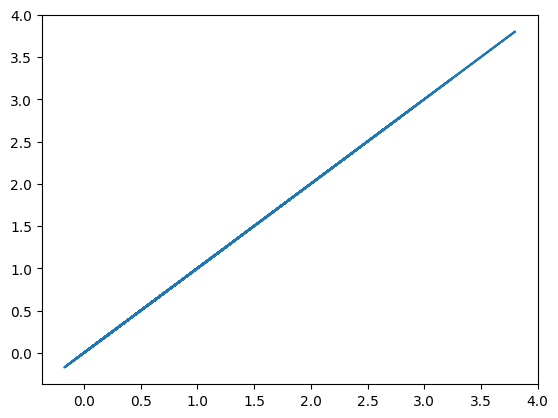

In [13]:
plt.plot(df_variability_3days_zero['Norm_Excess_Var(3_days)'], df_variability_3days_aver['Norm_Excess_Var(3_days)'])

In [14]:
#### open light curve files & FILTER
## Unconstrained Points become Upper Limit

## monthly

source_names_monthly = []
UL_bright_ratio_monthly = []

## case zero
nExcess_monthly_zero = []
unc_nExcess_monthly_zero = []
fvar_monthly_zero = []
unc_fvar_monthly_zero = []

## case average
nExcess_monthly_aver = []
unc_nExcess_monthly_aver = []
fvar_monthly_aver = []
unc_fvar_monthly_aver = []


for source_name in json_source_names:
    file_name = f'4FGL+{source_name}.json'
    source_data = Read_json_file(file_name, 'monthly', 'fixed')
    source_df = source_data.dataframe
    source_dict = source_data.dictionary
    
    filtered_df = filter_outliers(source_df)
    
    ## UL check
    if len(filtered_df['flux'].dropna()) != 0:
        bright_ratio = len(filtered_df['flux_upper_limits'].dropna()) / len(filtered_df['flux'].dropna())
    
    ## 50% cut
    if bright_ratio < 1.0:
        # print(bright_ratio)
        UL_bright_ratio_monthly.append(bright_ratio)
        
        ## input Upper Limits
        
        ## case zero
        df_case_zero = input_upperL(filtered_df, 'zero')
        variability = Estimate_variability(df_case_zero)
        sigma_nxs, err_sigma_nxs, fvar, err_fvar = variability.calculate_variability()
    
        source_names_monthly.append(source_name)
        
        nExcess_monthly_zero.append(sigma_nxs)
        unc_nExcess_monthly_zero.append(err_sigma_nxs)
        fvar_monthly_zero.append(fvar)
        unc_fvar_monthly_zero.append(err_fvar)
        
        ## case average
        df_case_average = input_upperL(filtered_df, 'average')
        variability_2 = Estimate_variability(df_case_average)
        sigma_nxs_2, err_sigma_nxs_2, fvar_2, err_fvar_2 = variability_2.calculate_variability()
        
        nExcess_monthly_aver.append(sigma_nxs_2)
        unc_nExcess_monthly_aver.append(err_sigma_nxs_2)
        fvar_monthly_aver.append(fvar_2)
        unc_fvar_monthly_aver.append(err_fvar_2)
    
df_variability_monthly_zero = pd.DataFrame(list(zip(source_names_monthly, UL_bright_ratio_monthly,
                                                     nExcess_monthly_zero, unc_nExcess_monthly_zero,
                                                     fvar_monthly_zero, unc_fvar_monthly_zero)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(monthly)', 'Unc_Norm_Excess_Var(monthly)',
                                                      'Frac_Variability(monthly)', 'Unc_Frac_Variability(monthly)'])

df_variability_monthly_aver = pd.DataFrame(list(zip(source_names_monthly, UL_bright_ratio_monthly,
                                                     nExcess_monthly_aver, unc_nExcess_monthly_aver,
                                                     fvar_monthly_aver, unc_fvar_monthly_aver)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(monthly)', 'Unc_Norm_Excess_Var(monthly)',
                                                      'Frac_Variability(monthly)', 'Unc_Frac_Variability(monthly)'])

/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/variability_estimator.py:73: RuntimeWarning: invalid value encountered in sqrt
  self.unc_normalized_excess_variance = np.sqrt( (term1)**2 + ( (term2)**2 * self.normalized_excess_variance) )
/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/variability_estimator.py:73: RuntimeWarning: invalid value encountered in sqrt
  self.unc_normalized_excess_variance = np.sqrt( (term1)**2 + ( (term2)**2 * self.normalized_excess_variance) )
/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/variability_estimator.py:73: RuntimeWarning: invalid value encountered in sqrt
  self.unc_normalized_excess_variance = np.sqrt( (term1)**2 + ( (term2)**2 * self.normalized_excess_variance) )
/Users/luanareis/Documents/GitHub/CTA_AGN_Pop_Variability/4LAC_variability_analysis/variability_estimator.py:73: RuntimeWarning: invalid value encountered in sqrt
  self.unc_n

In [15]:
df_variability_monthly_zero

,Source_Name,Bright_Ratio,Norm_Excess_Var(monthly),Unc_Norm_Excess_Var(monthly),Frac_Variability(monthly),Unc_Frac_Variability(monthly)
0,J0001.2-0747,0.846154,-0.100559,0.022187,0.000000,0.100000
1,J0001.5+2113,0.525253,1.035276,0.036008,1.017485,0.017695
2,J0009.3+5030,0.060606,0.120650,0.022296,0.347346,0.032095
3,J0011.4+0057,0.960000,0.552667,0.058103,0.743416,0.039078
4,J0021.5-2552,0.759036,-0.058217,0.026993,0.000000,0.100000
...,...,...,...,...,...,...
576,J2334.8+1432,0.813559,0.007318,0.049091,0.085547,0.286923
577,J2338.0-0230,0.666667,0.178128,0.040325,0.422052,0.047772
578,J2345.2-1555,0.257576,1.333665,0.029825,1.154844,0.012913
579,J2347.0+5141,0.046512,0.101521,0.020364,0.318624,0.031956


In [16]:
df_variability_monthly_aver

,Source_Name,Bright_Ratio,Norm_Excess_Var(monthly),Unc_Norm_Excess_Var(monthly),Frac_Variability(monthly),Unc_Frac_Variability(monthly)
0,J0001.2-0747,0.846154,-0.100559,0.022187,0.000000,0.100000
1,J0001.5+2113,0.525253,1.035276,0.036008,1.017485,0.017695
2,J0009.3+5030,0.060606,0.120650,0.022296,0.347346,0.032095
3,J0011.4+0057,0.960000,0.552667,0.058103,0.743416,0.039078
4,J0021.5-2552,0.759036,-0.058217,0.026993,0.000000,0.100000
...,...,...,...,...,...,...
576,J2334.8+1432,0.813559,0.007318,0.049091,0.085547,0.286923
577,J2338.0-0230,0.666667,0.178128,0.040325,0.422052,0.047772
578,J2345.2-1555,0.257576,1.333665,0.029825,1.154844,0.012913
579,J2347.0+5141,0.046512,0.101521,0.020364,0.318624,0.031956


In [17]:
#### open light curve files & FILTER
## Unconstrained Points become Upper Limit

## weekly

source_names_weekly = []
UL_bright_ratio_weekly = []

## case zero
nExcess_weekly_zero = []
unc_nExcess_weekly_zero = []
fvar_weekly_zero = []
unc_fvar_weekly_zero = []

## case average
nExcess_weekly_aver = []
unc_nExcess_weekly_aver = []
fvar_weekly_aver = []
unc_fvar_weekly_aver = []


for source_name in json_source_names:
    file_name = f'4FGL+{source_name}.json'
    source_data = Read_json_file(file_name, 'weekly', 'fixed')
    source_df = source_data.dataframe
    source_dict = source_data.dictionary
    
    filtered_df = filter_outliers(source_df)
    
    ## UL check
    bright_ratio = len(filtered_df['flux_upper_limits'].dropna()) / len(filtered_df['flux'].dropna())
    
    ## 50% cut
    if bright_ratio < 1.0:
        # print(bright_ratio)
        UL_bright_ratio_weekly.append(bright_ratio)
        
        ## input Upper Limits
        
        ## case zero
        df_case_zero = input_upperL(filtered_df, 'zero')
        variability = Estimate_variability(df_case_zero)
        sigma_nxs, err_sigma_nxs, fvar, err_fvar = variability.calculate_variability()
    
        source_names_weekly.append(source_name)
        
        nExcess_weekly_zero.append(sigma_nxs)
        unc_nExcess_weekly_zero.append(err_sigma_nxs)
        fvar_weekly_zero.append(fvar)
        unc_fvar_weekly_zero.append(err_fvar)
        
        ## case average
        df_case_average = input_upperL(filtered_df, 'average')
        variability_2 = Estimate_variability(df_case_average)
        sigma_nxs_2, err_sigma_nxs_2, fvar_2, err_fvar_2 = variability_2.calculate_variability()
        
        nExcess_weekly_aver.append(sigma_nxs_2)
        unc_nExcess_weekly_aver.append(err_sigma_nxs_2)
        fvar_weekly_aver.append(fvar_2)
        unc_fvar_weekly_aver.append(err_fvar_2)
    
df_variability_weekly_zero = pd.DataFrame(list(zip(source_names_weekly, UL_bright_ratio_weekly,
                                                     nExcess_weekly_zero, unc_nExcess_weekly_zero,
                                                     fvar_weekly_zero, unc_fvar_weekly_zero)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(weekly)', 'Unc_Norm_Excess_Var(weekly)',
                                                      'Frac_Variability(weekly)', 'Unc_Frac_Variability(weekly)'])

df_variability_weekly_aver = pd.DataFrame(list(zip(source_names_weekly, UL_bright_ratio_weekly,
                                                     nExcess_weekly_aver, unc_nExcess_weekly_aver,
                                                     fvar_weekly_aver, unc_fvar_weekly_aver)),
                                            columns =['Source_Name', 'Bright_Ratio', 'Norm_Excess_Var(weekly)', 'Unc_Norm_Excess_Var(weekly)',
                                                      'Frac_Variability(weekly)', 'Unc_Frac_Variability(weekly)'])

In [18]:
df_variability_weekly_zero

,Source_Name,Bright_Ratio,Norm_Excess_Var(weekly),Unc_Norm_Excess_Var(weekly),Frac_Variability(weekly),Unc_Frac_Variability(weekly)
0,J0009.3+5030,0.666667,-0.048938,0.016023,0.000000,0.100000
1,J0022.5+0608,0.678947,0.028298,0.019292,0.168219,0.057342
2,J0030.3-4224,0.824207,0.468673,0.031453,0.684597,0.022972
3,J0033.5-1921,0.536585,-0.116141,0.014019,0.000000,0.100000
4,J0035.9+5950,0.849582,-0.018246,0.028490,0.000000,0.100000
...,...,...,...,...,...,...
214,J2323.8+4210,0.895954,-0.148953,0.010768,0.000000,0.100000
215,J2329.3-4955,0.449064,1.209844,0.017709,1.099929,0.008050
216,J2345.2-1555,0.643357,1.015617,0.025591,1.007778,0.012697
217,J2347.0+5141,0.552133,-0.039790,0.018133,0.000000,0.100000


In [19]:
df_variability_weekly_aver

,Source_Name,Bright_Ratio,Norm_Excess_Var(weekly),Unc_Norm_Excess_Var(weekly),Frac_Variability(weekly),Unc_Frac_Variability(weekly)
0,J0009.3+5030,0.666667,-0.048938,0.016023,0.000000,0.100000
1,J0022.5+0608,0.678947,0.028298,0.019292,0.168219,0.057342
2,J0030.3-4224,0.824207,0.468673,0.031453,0.684597,0.022972
3,J0033.5-1921,0.536585,-0.116141,0.014019,0.000000,0.100000
4,J0035.9+5950,0.849582,-0.018246,0.028490,0.000000,0.100000
...,...,...,...,...,...,...
214,J2323.8+4210,0.895954,-0.148953,0.010768,0.000000,0.100000
215,J2329.3-4955,0.449064,1.209844,0.017709,1.099929,0.008050
216,J2345.2-1555,0.643357,1.015617,0.025591,1.007778,0.012697
217,J2347.0+5141,0.552133,-0.039790,0.018133,0.000000,0.100000


In [20]:
## unifying in a single dataframe

In [21]:
## merging our estimates

df_filtered_4lac_luana_dr3 = df_filtered_4lac_luana_dr3.merge(df_variability_3days_zero, on='Source_Name', how='left')
df_filtered_4lac_luana_dr3 = df_filtered_4lac_luana_dr3.merge(df_variability_weekly_zero, on='Source_Name', how='left')
df_filtered_4lac_luana_dr3 = df_filtered_4lac_luana_dr3.merge(df_variability_monthly_zero, on='Source_Name', how='left')

In [22]:
## merging our estimates

df_4lac_luana_dr3 = df_4lac_luana_dr3.merge(df_variability_3days_zero, on='Source_Name', how='left')
df_4lac_luana_dr3 = df_4lac_luana_dr3.merge(df_variability_weekly_zero, on='Source_Name', how='left')
df_4lac_luana_dr3 = df_4lac_luana_dr3.merge(df_variability_monthly_zero, on='Source_Name', how='left')

In [23]:
## a few plots

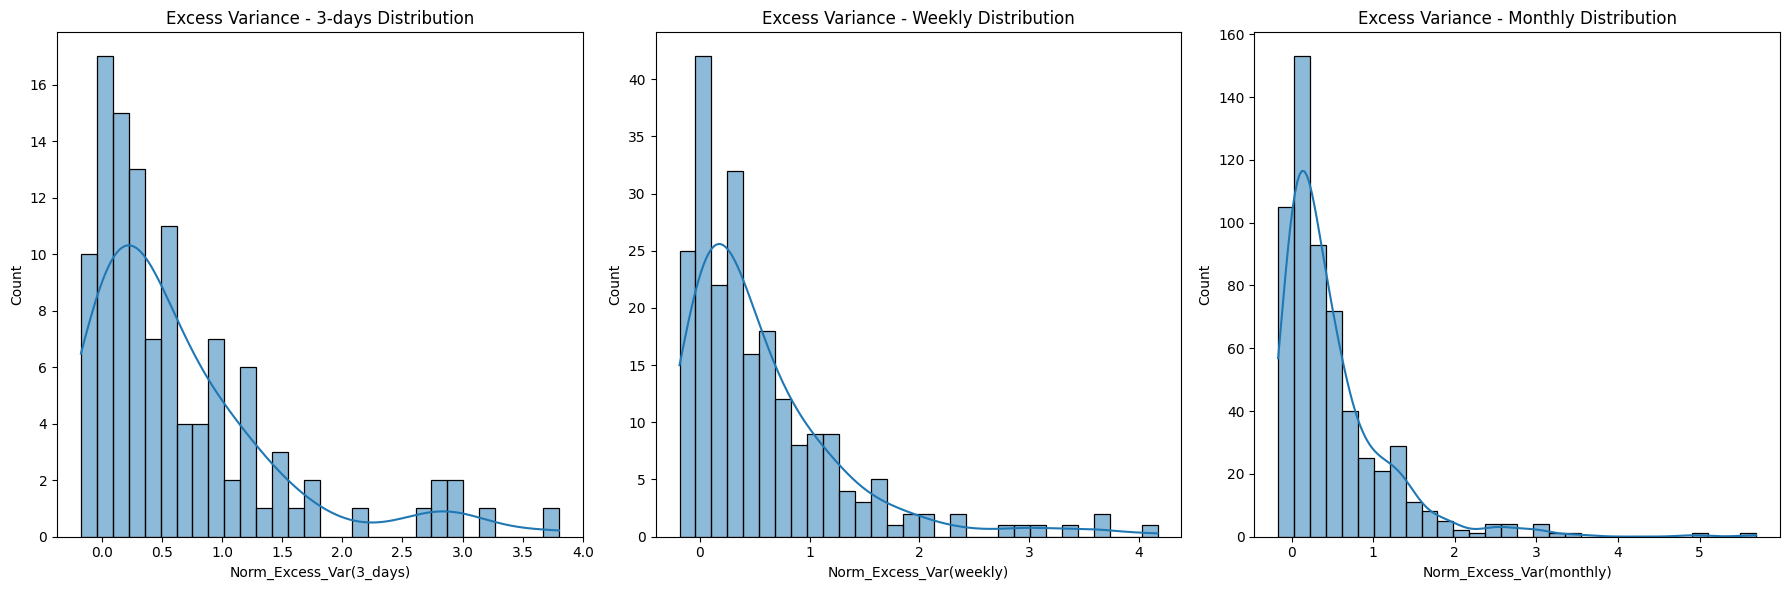

In [24]:
## Histograms

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.histplot(df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Excess Variance - 3-days Distribution')

sns.histplot(df_filtered_4lac_luana_dr3['Norm_Excess_Var(weekly)'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Excess Variance - Weekly Distribution')

sns.histplot(df_filtered_4lac_luana_dr3['Norm_Excess_Var(monthly)'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Excess Variance - Monthly Distribution')

plt.tight_layout()

plt.savefig('plots/excess_variance_distributions.png')

plt.show()


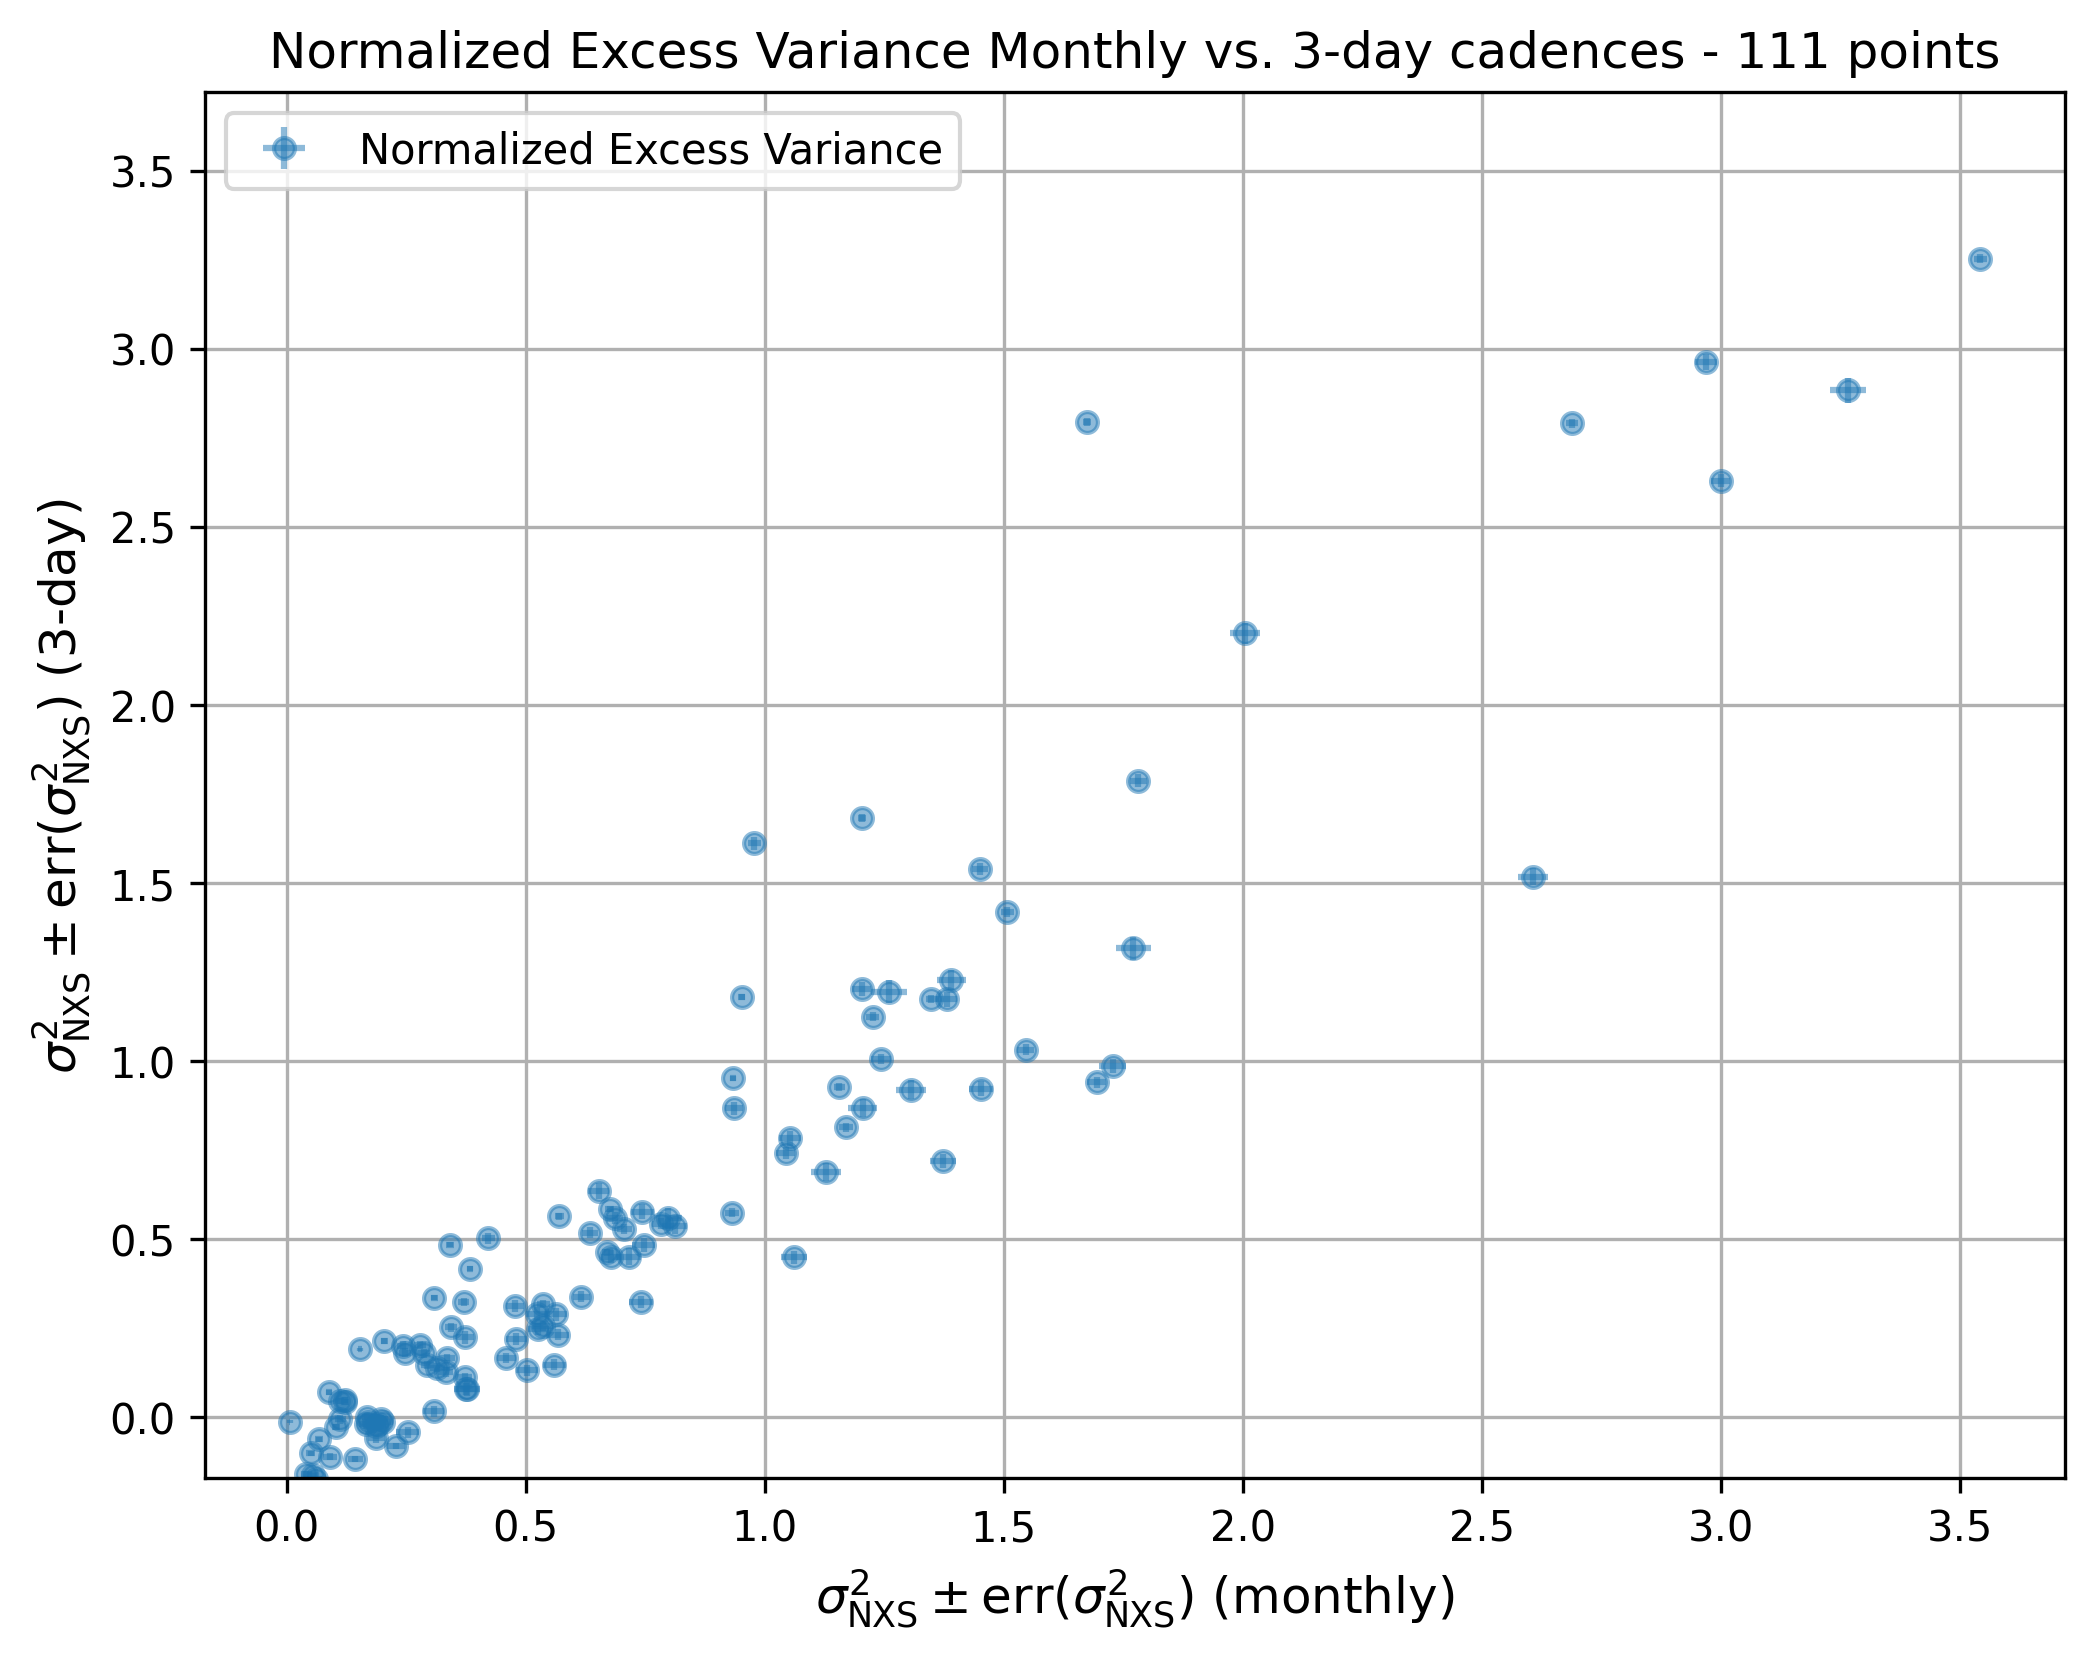

In [25]:
## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

plt.figure(figsize=(8,6), dpi=300)

x = df_filtered_4lac_luana_dr3[df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'].notna()]

plt.errorbar(df_filtered_4lac_luana_dr3['Norm_Excess_Var(monthly)'], df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'],
             xerr=df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(monthly)'], yerr=df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(3_days)'],
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x)} points', fontsize=12)
plt.legend()

# plt.xscale('log')
# plt.yscale('log')

plt.ylim(plt.xlim())
# plt.xlim(plt.ylim())

plt.grid(True)
plt.savefig('plots/monthly_vs_3days.png',dpi=300)
plt.show()

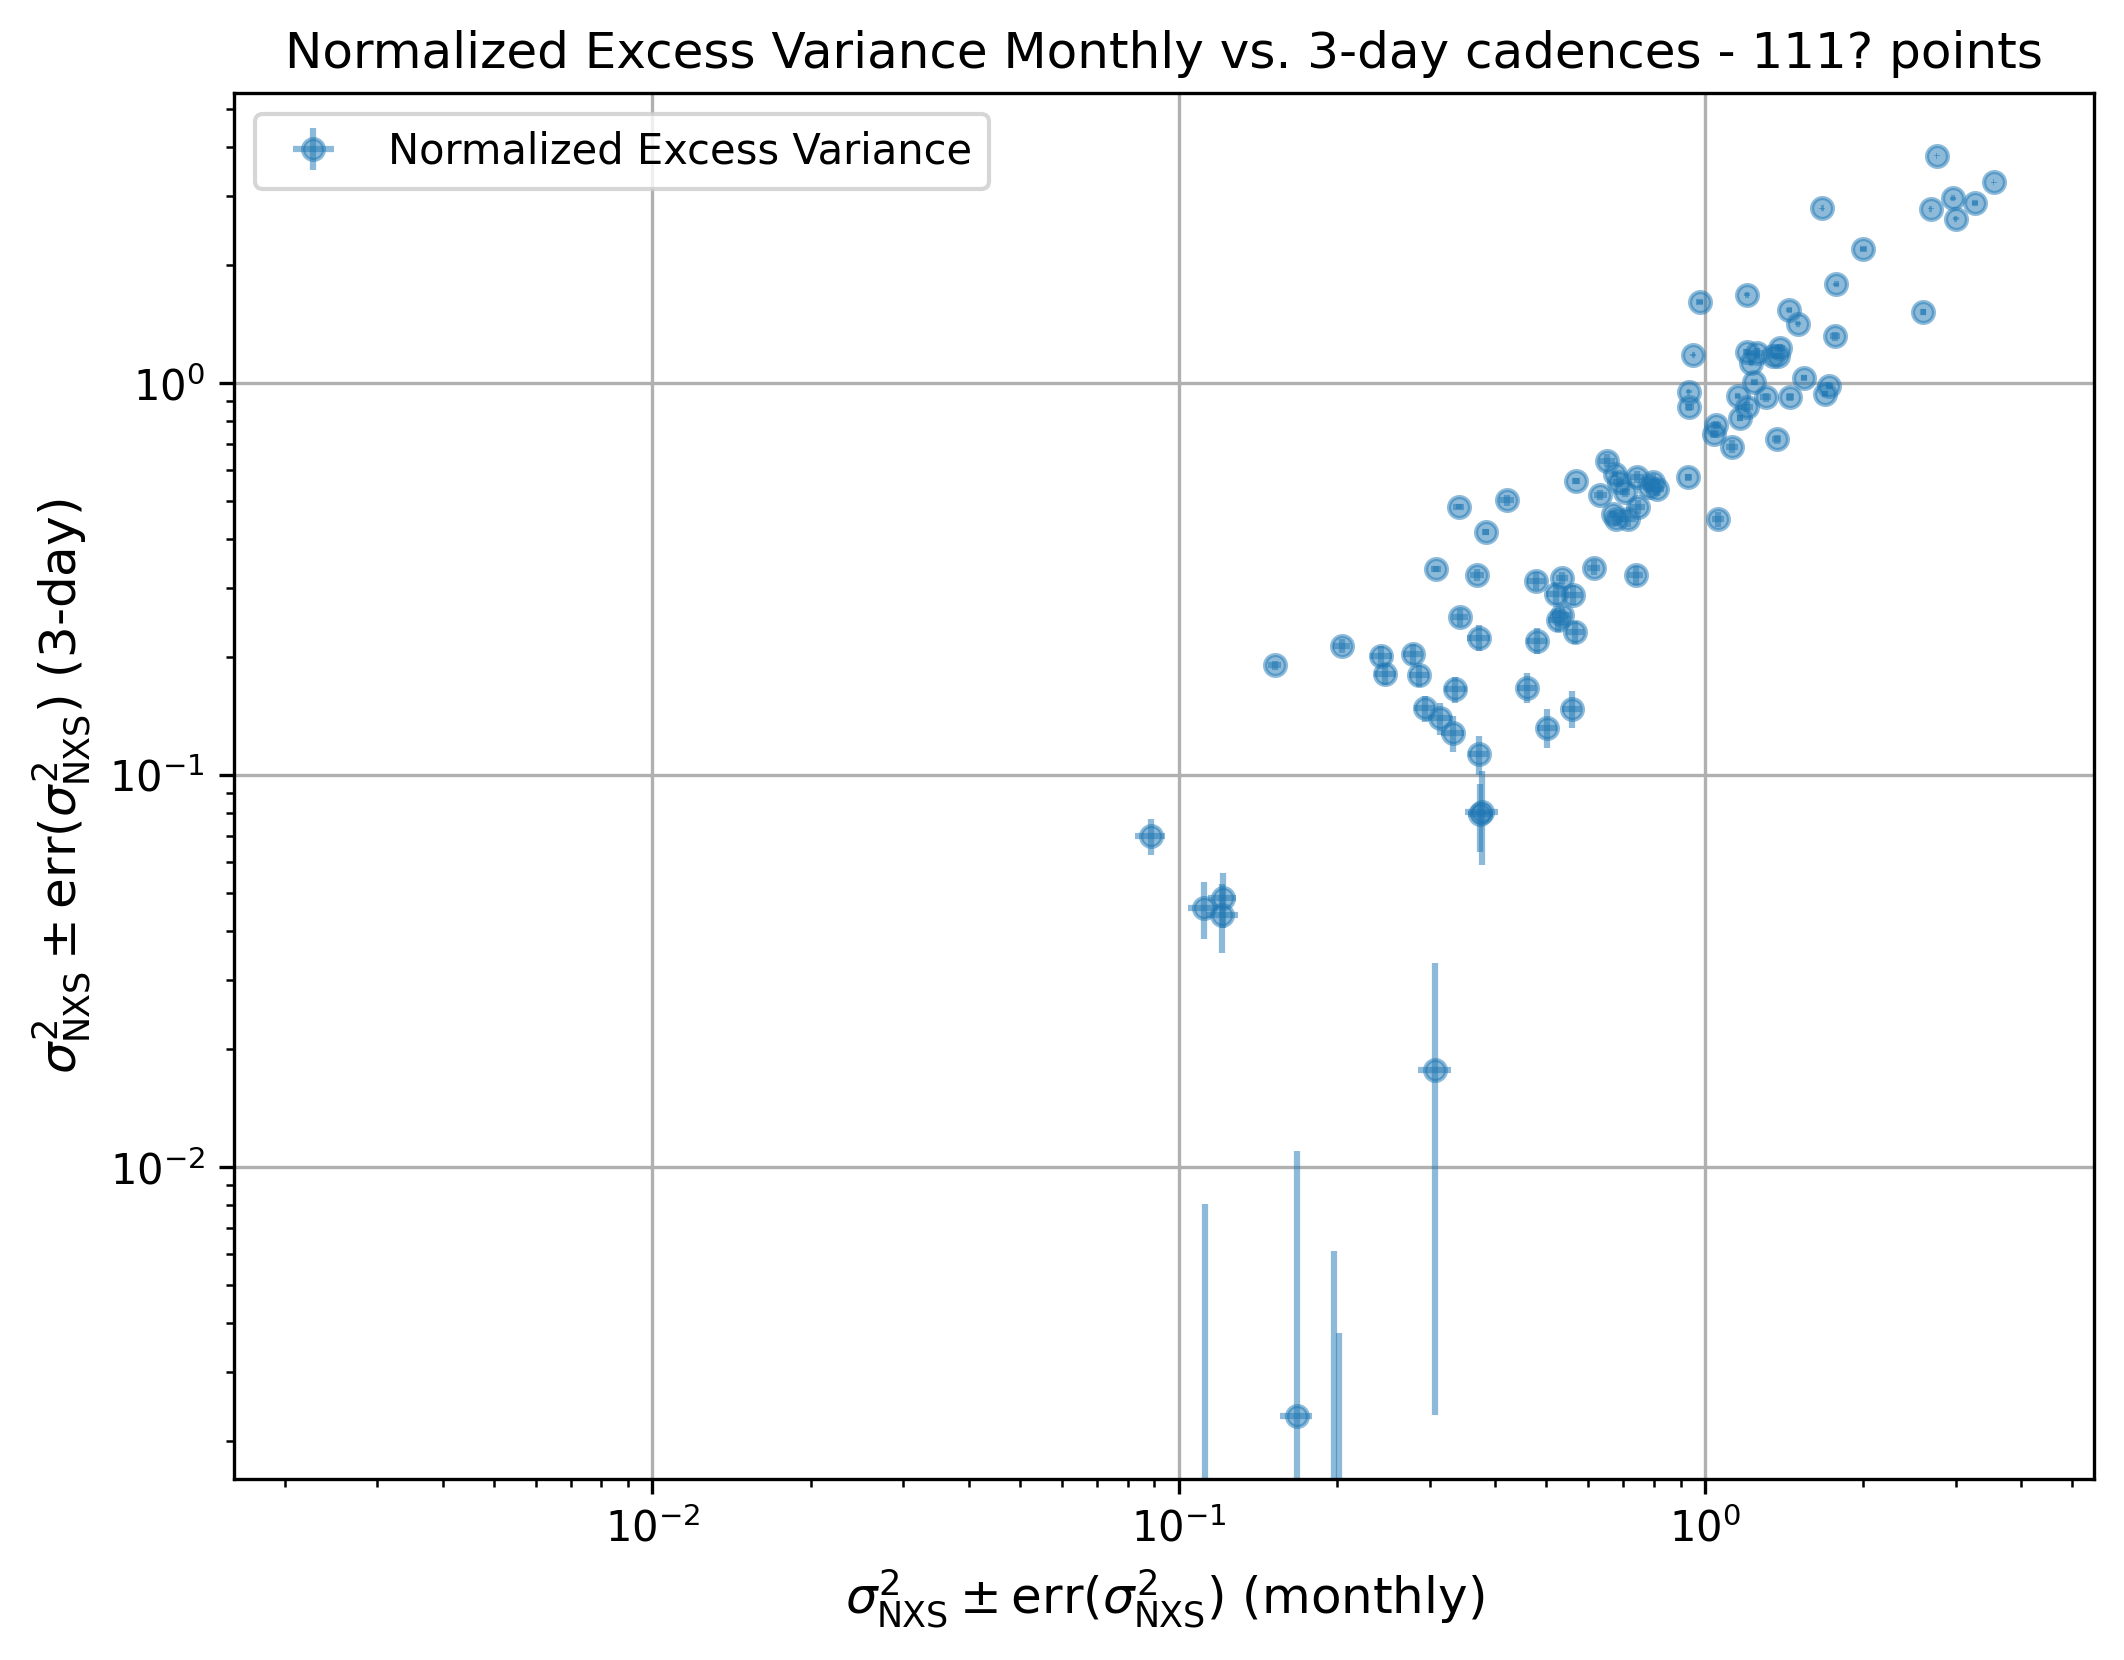

In [26]:
## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

plt.figure(figsize=(8,6), dpi=300)

x = df_filtered_4lac_luana_dr3[df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'].notna()]
# x = x[x > 0]

plt.errorbar(df_filtered_4lac_luana_dr3['Norm_Excess_Var(monthly)'], df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)'],
             xerr=df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(monthly)'], yerr=df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(3_days)'],
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x)}? points', fontsize=12)
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.xlim(plt.ylim())
# plt.ylim(plt.xlim())

plt.grid(True)
plt.savefig('plots/monthly_vs_3days_log.png',dpi=300)
plt.show()

In [27]:
x = df_filtered_4lac_luana_dr3['Norm_Excess_Var(monthly)']
y = df_filtered_4lac_luana_dr3['Norm_Excess_Var(3_days)']
x_err = df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(monthly)']
y_err = df_filtered_4lac_luana_dr3['Unc_Norm_Excess_Var(3_days)']

In [28]:
## filter out non-positive values
valid_indices = (x > 0) & (y > 0)

x = x[valid_indices]
y = y[valid_indices]
x_err = x_err[valid_indices]
y_err = y_err[valid_indices]

In [29]:
len(x)

92

In [30]:
## Log transformation
log_x = np.log(x)
log_y = np.log(y)
log_x_err = x_err / x  # relative error in log scale
log_y_err = y_err / y  # relative error in log scale

Fitted parameter: a = 1.3674165153300395


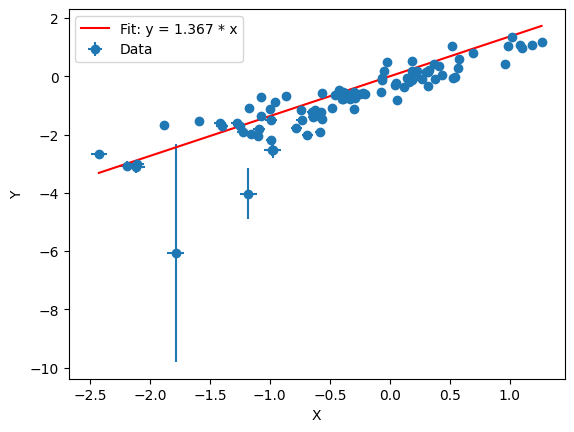

In [31]:
import scipy.odr as odr

def power_law_model(B, x):
    return B[0] * x

## create a model object
power_model = odr.Model(power_law_model)

x_data = log_x
y_data = log_y

x_err = log_x_err 
y_err = log_y_err

## prepare the data for ODR
data = odr.RealData(x_data, y_data, sx=x_err, sy=y_err)

# Set initial guess for the parameters [a, b]
initial_guess = [1.3, 1.0]

# Set up ODR with the model and data
odr_instance = odr.ODR(data, power_model, beta0=initial_guess)

# Run the ODR fitting
output = odr_instance.run()

# Extract the fitted parameters
a, b = output.beta
a = a+0.2
print(f"Fitted parameter: a = {a}")

# Plot the data and the fitted model
x_fit = np.linspace(min(x_data), max(x_data), 1000)
y_fit = power_law_model([a, b], x_fit)

plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, fmt='o', label='Data')
plt.plot(x_fit, y_fit, label=f'Fit: y = {a:.3f} * x', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [32]:
table_4lac_luana_dr3 = Table.from_pandas(df_4lac_luana_dr3)
table_filtered_4lac_luana_dr3 = Table.from_pandas(df_filtered_4lac_luana_dr3) 

## Selection of sources which show significant variability on a monthly timescale

--> only select sources with $\sigma_{NXS}^{2}$(monthly) - 3*err$[\sigma_{NXS}^{2}]$(monthly) > 0

In [33]:
## monthly significant 3 sigma

In [34]:
# selected_indices = []

# for index, row in enumerate(table_filtered_4lac_luana_dr3):
    
#     ## Check if V_NXS and eV_NXS are not NaN
#     if not (row['Norm_Excess_Var(monthly)'] is None or row['Unc_Norm_Excess_Var(monthly)'] is None) and ( not NaN):
        
#         ## 3 sigma criteria
#         if row['Norm_Excess_Var(monthly)'] - 3 * row['Unc_Norm_Excess_Var(monthly)'] > 0:
            
#             selected_indices.append(index) # add index to list


# if selected_indices:
    
#     selected_table_monthly = table_filtered_4lac_luana_dr3[selected_indices]
    
# else:
#     print("No rows satisfy the condition.")


In [35]:
selected_indices = []

for index, row in enumerate(table_filtered_4lac_luana_dr3):
    
    ## Check if 'Norm_Excess_Var(monthly)' and 'Unc_Norm_Excess_Var(monthly)' are not None and not NaN
    if (row['Norm_Excess_Var(monthly)'] is not None and not pd.isna(row['Norm_Excess_Var(monthly)'])) and \
       (row['Unc_Norm_Excess_Var(monthly)'] is not None and not pd.isna(row['Unc_Norm_Excess_Var(monthly)'])):
        
        ## 3 sigma criteria
        if row['Norm_Excess_Var(monthly)'] - 3 * row['Unc_Norm_Excess_Var(monthly)'] > 0:
            selected_indices.append(index)  # add index to list

if selected_indices:
    table_selected_monthly = table_filtered_4lac_luana_dr3[selected_indices]
else:
    print("No rows satisfy the condition.")


In [36]:
selected_table_monthly = table_selected_monthly.to_pandas()

In [37]:
selected_table_monthly

,Source_Name,SpectrumType,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Spectrum_Flux_Estimated,Bright_Ratio_x,Norm_Excess_Var(3_days),...,Bright_Ratio_y,Norm_Excess_Var(weekly),Unc_Norm_Excess_Var(weekly),Frac_Variability(weekly),Unc_Frac_Variability(weekly),Bright_Ratio,Norm_Excess_Var(monthly),Unc_Norm_Excess_Var(monthly),Frac_Variability(monthly),Unc_Frac_Variability(monthly)
0,J0001.5+2113,LogParabola,fsrq,ISP,1910.935791,0.996138,0.213478,6.391699e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.525253,1.035276,0.036008,1.017485,0.017695
1,J0009.3+5030,LogParabola,bll,HSP,204.735321,0.408724,0.092225,1.675709e-08,NaN,NaN,...,0.666667,-0.048938,0.016023,0.000000,0.100000,0.060606,0.120650,0.022296,0.347346,0.032095
2,J0011.4+0057,LogParabola,fsrq,LSP,231.066986,0.984393,0.219003,1.199554e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.960000,0.552667,0.058103,0.743416,0.039078
3,J0022.5+0608,LogParabola,bll,LSP,218.544571,0.459733,0.102740,2.687140e-08,NaN,NaN,...,0.678947,0.028298,0.019292,0.168219,0.057342,0.054545,0.228445,0.026166,0.477960,0.027372
4,J0030.3-4224,LogParabola,fsrq,LSP,138.983154,0.370553,0.086036,2.880950e-08,NaN,NaN,...,0.824207,0.468673,0.031453,0.684597,0.022972,0.157143,0.652814,0.035109,0.807969,0.021727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,J2331.0-2147,LogParabola,fsrq,LSP,289.819183,0.805878,0.177524,2.039808e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.305085,0.307712,0.035151,0.554718,0.031684
428,J2338.0-0230,PowerLaw,fsrq,LSP,136.035965,0.578452,0.134122,2.454024e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.666667,0.178128,0.040325,0.422052,0.047772
429,J2345.2-1555,LogParabola,FSRQ,LSP,3702.562988,0.890338,0.190321,8.977745e-08,NaN,NaN,...,0.643357,1.015617,0.025591,1.007778,0.012697,0.257576,1.333665,0.029825,1.154844,0.012913
430,J2347.0+5141,LogParabola,bll,HSP,58.688427,0.201833,0.052628,1.449774e-08,NaN,NaN,...,0.552133,-0.039790,0.018133,0.000000,0.100000,0.046512,0.101521,0.020364,0.318624,0.031956


In [38]:
## plot Normalized Excess Variance

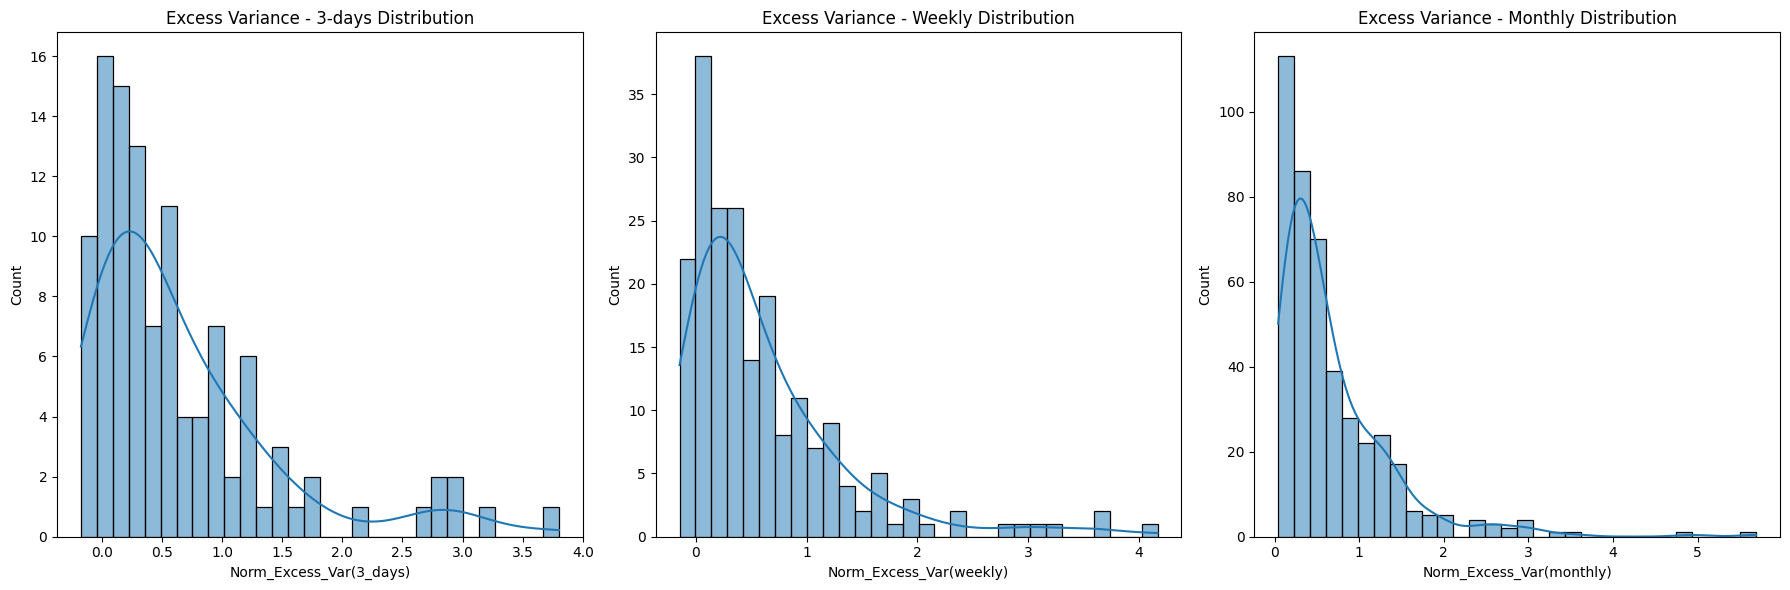

In [39]:
## Histograms

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.histplot(selected_table_monthly['Norm_Excess_Var(3_days)'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Excess Variance - 3-days Distribution')

sns.histplot(selected_table_monthly['Norm_Excess_Var(weekly)'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Excess Variance - Weekly Distribution')

sns.histplot(selected_table_monthly['Norm_Excess_Var(monthly)'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Excess Variance - Monthly Distribution')

plt.tight_layout()

plt.savefig('plots/selected_excess_variance_distributions.png')

plt.show()


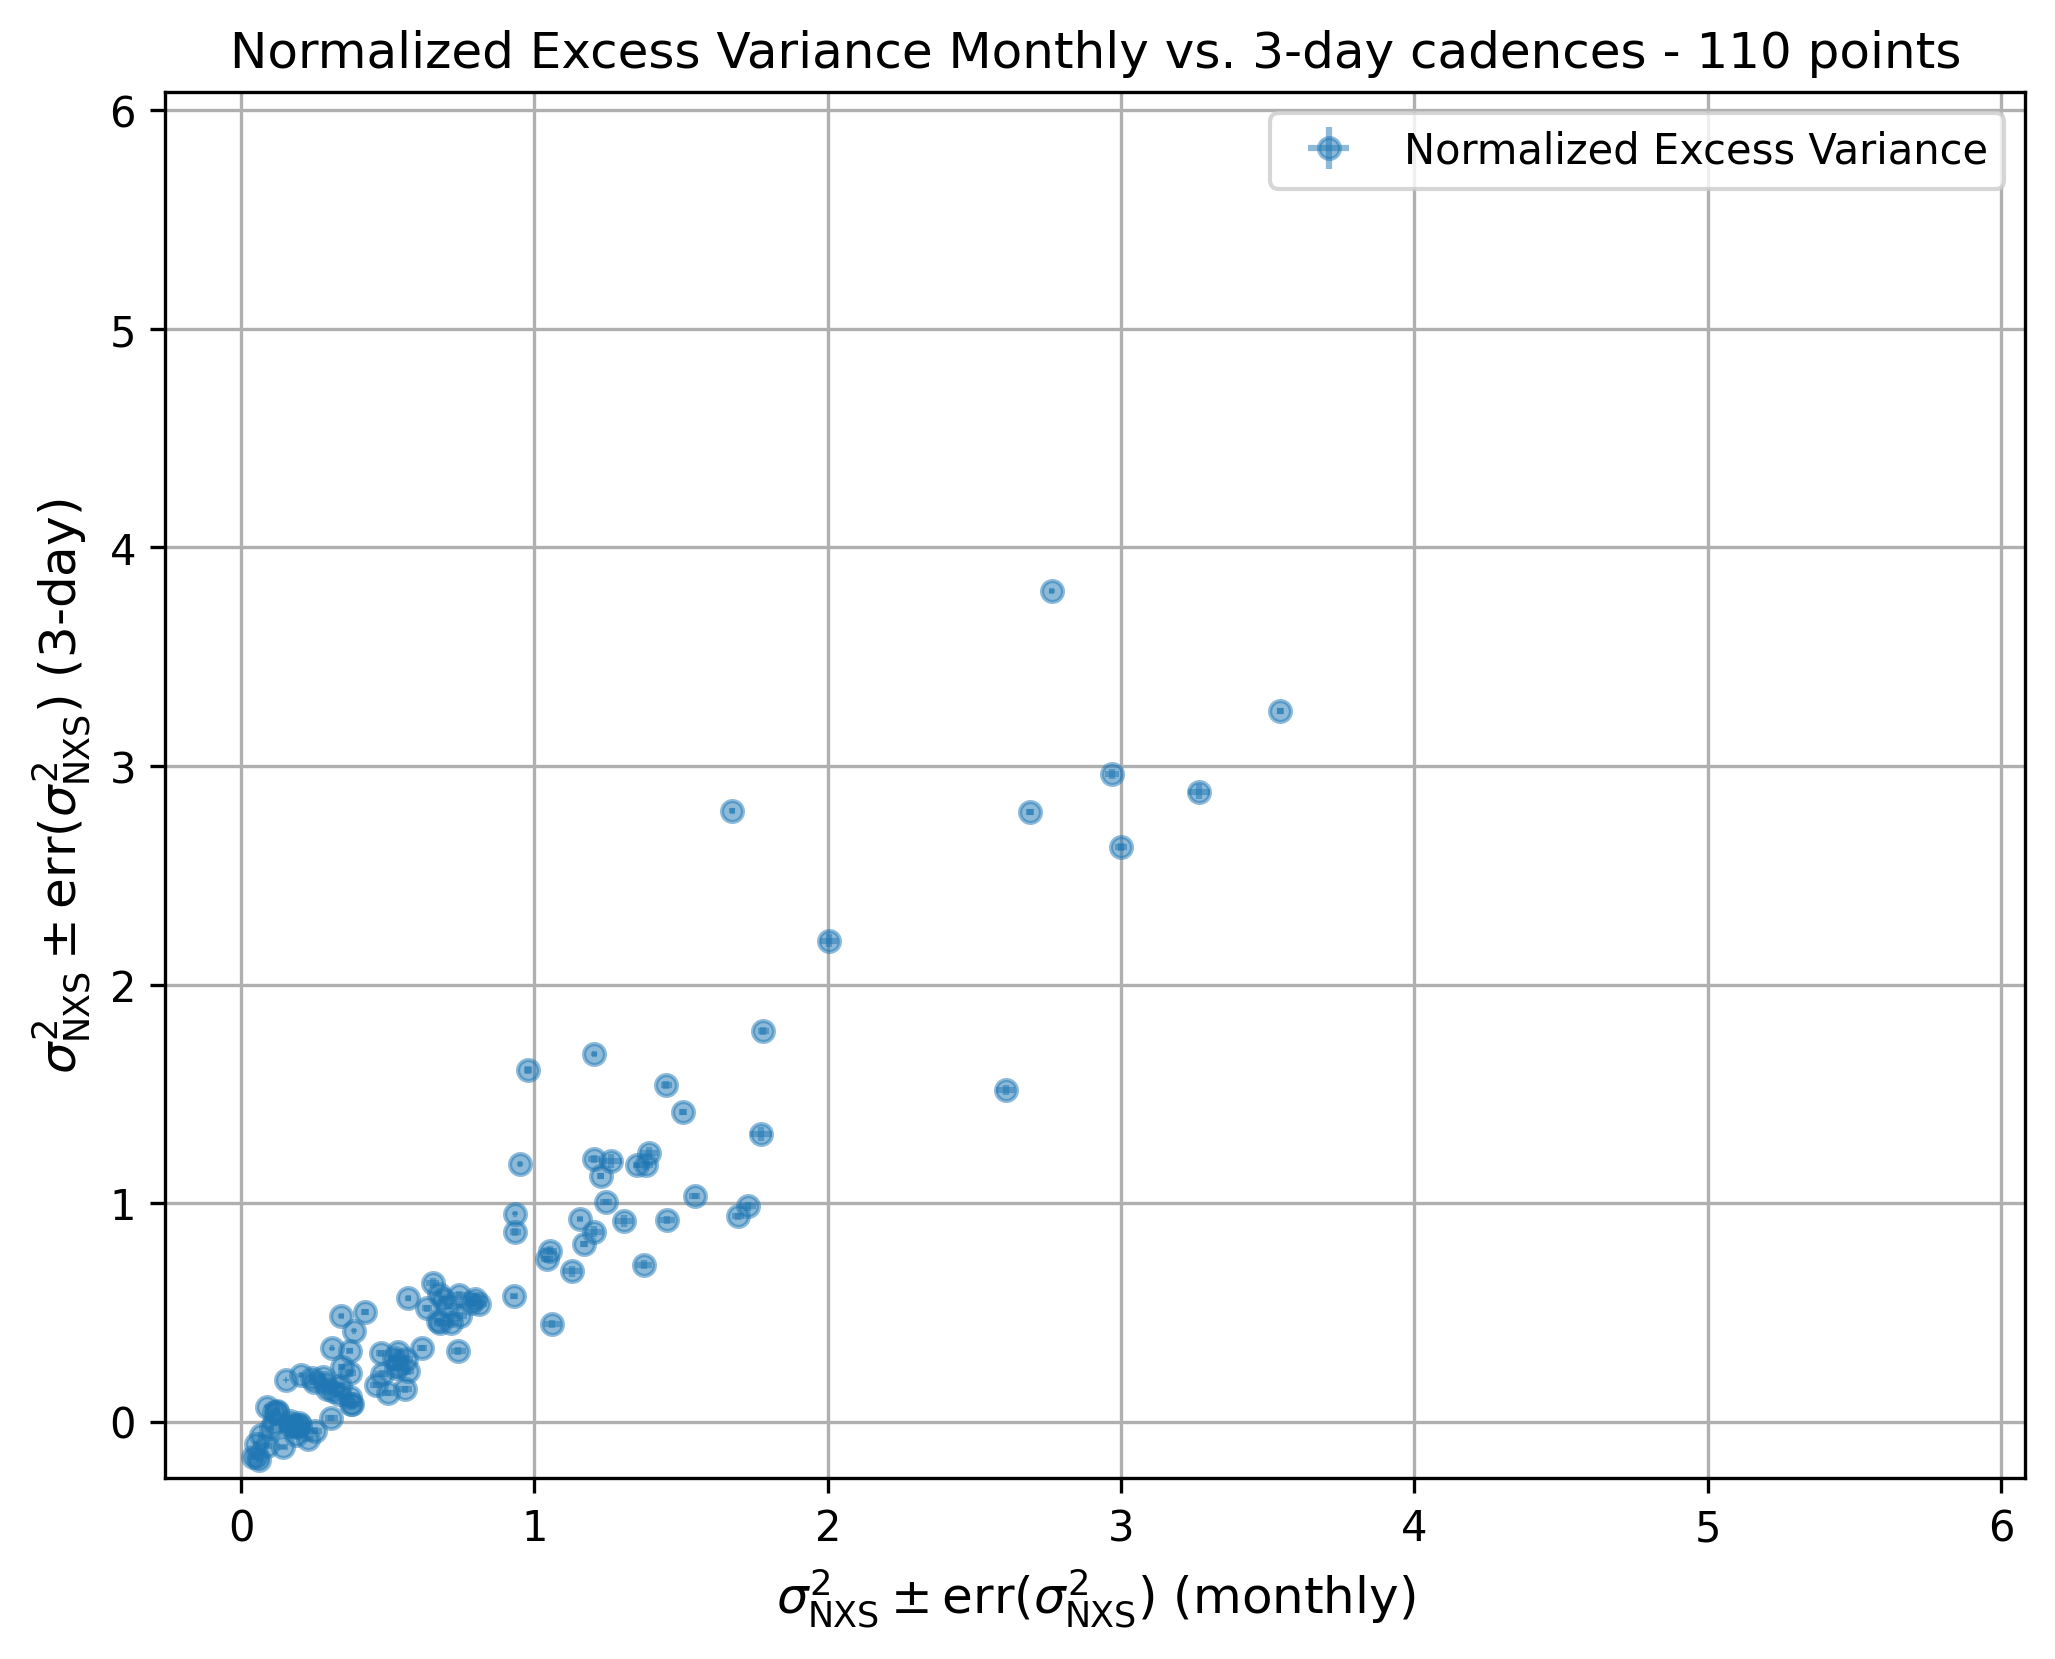

In [40]:
## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

plt.figure(figsize=(8,6), dpi=300)

x = selected_table_monthly[selected_table_monthly['Norm_Excess_Var(3_days)'].notna()]

plt.errorbar(selected_table_monthly['Norm_Excess_Var(monthly)'], selected_table_monthly['Norm_Excess_Var(3_days)'],
             xerr=selected_table_monthly['Unc_Norm_Excess_Var(monthly)'], yerr=selected_table_monthly['Unc_Norm_Excess_Var(3_days)'],
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x)} points', fontsize=12)
plt.legend()

# plt.xscale('log')
# plt.yscale('log')

plt.ylim(plt.xlim())
# plt.xlim(plt.ylim())

plt.grid(True)
plt.savefig('plots/selected_monthly_vs_3days.png',dpi=300)
plt.show()

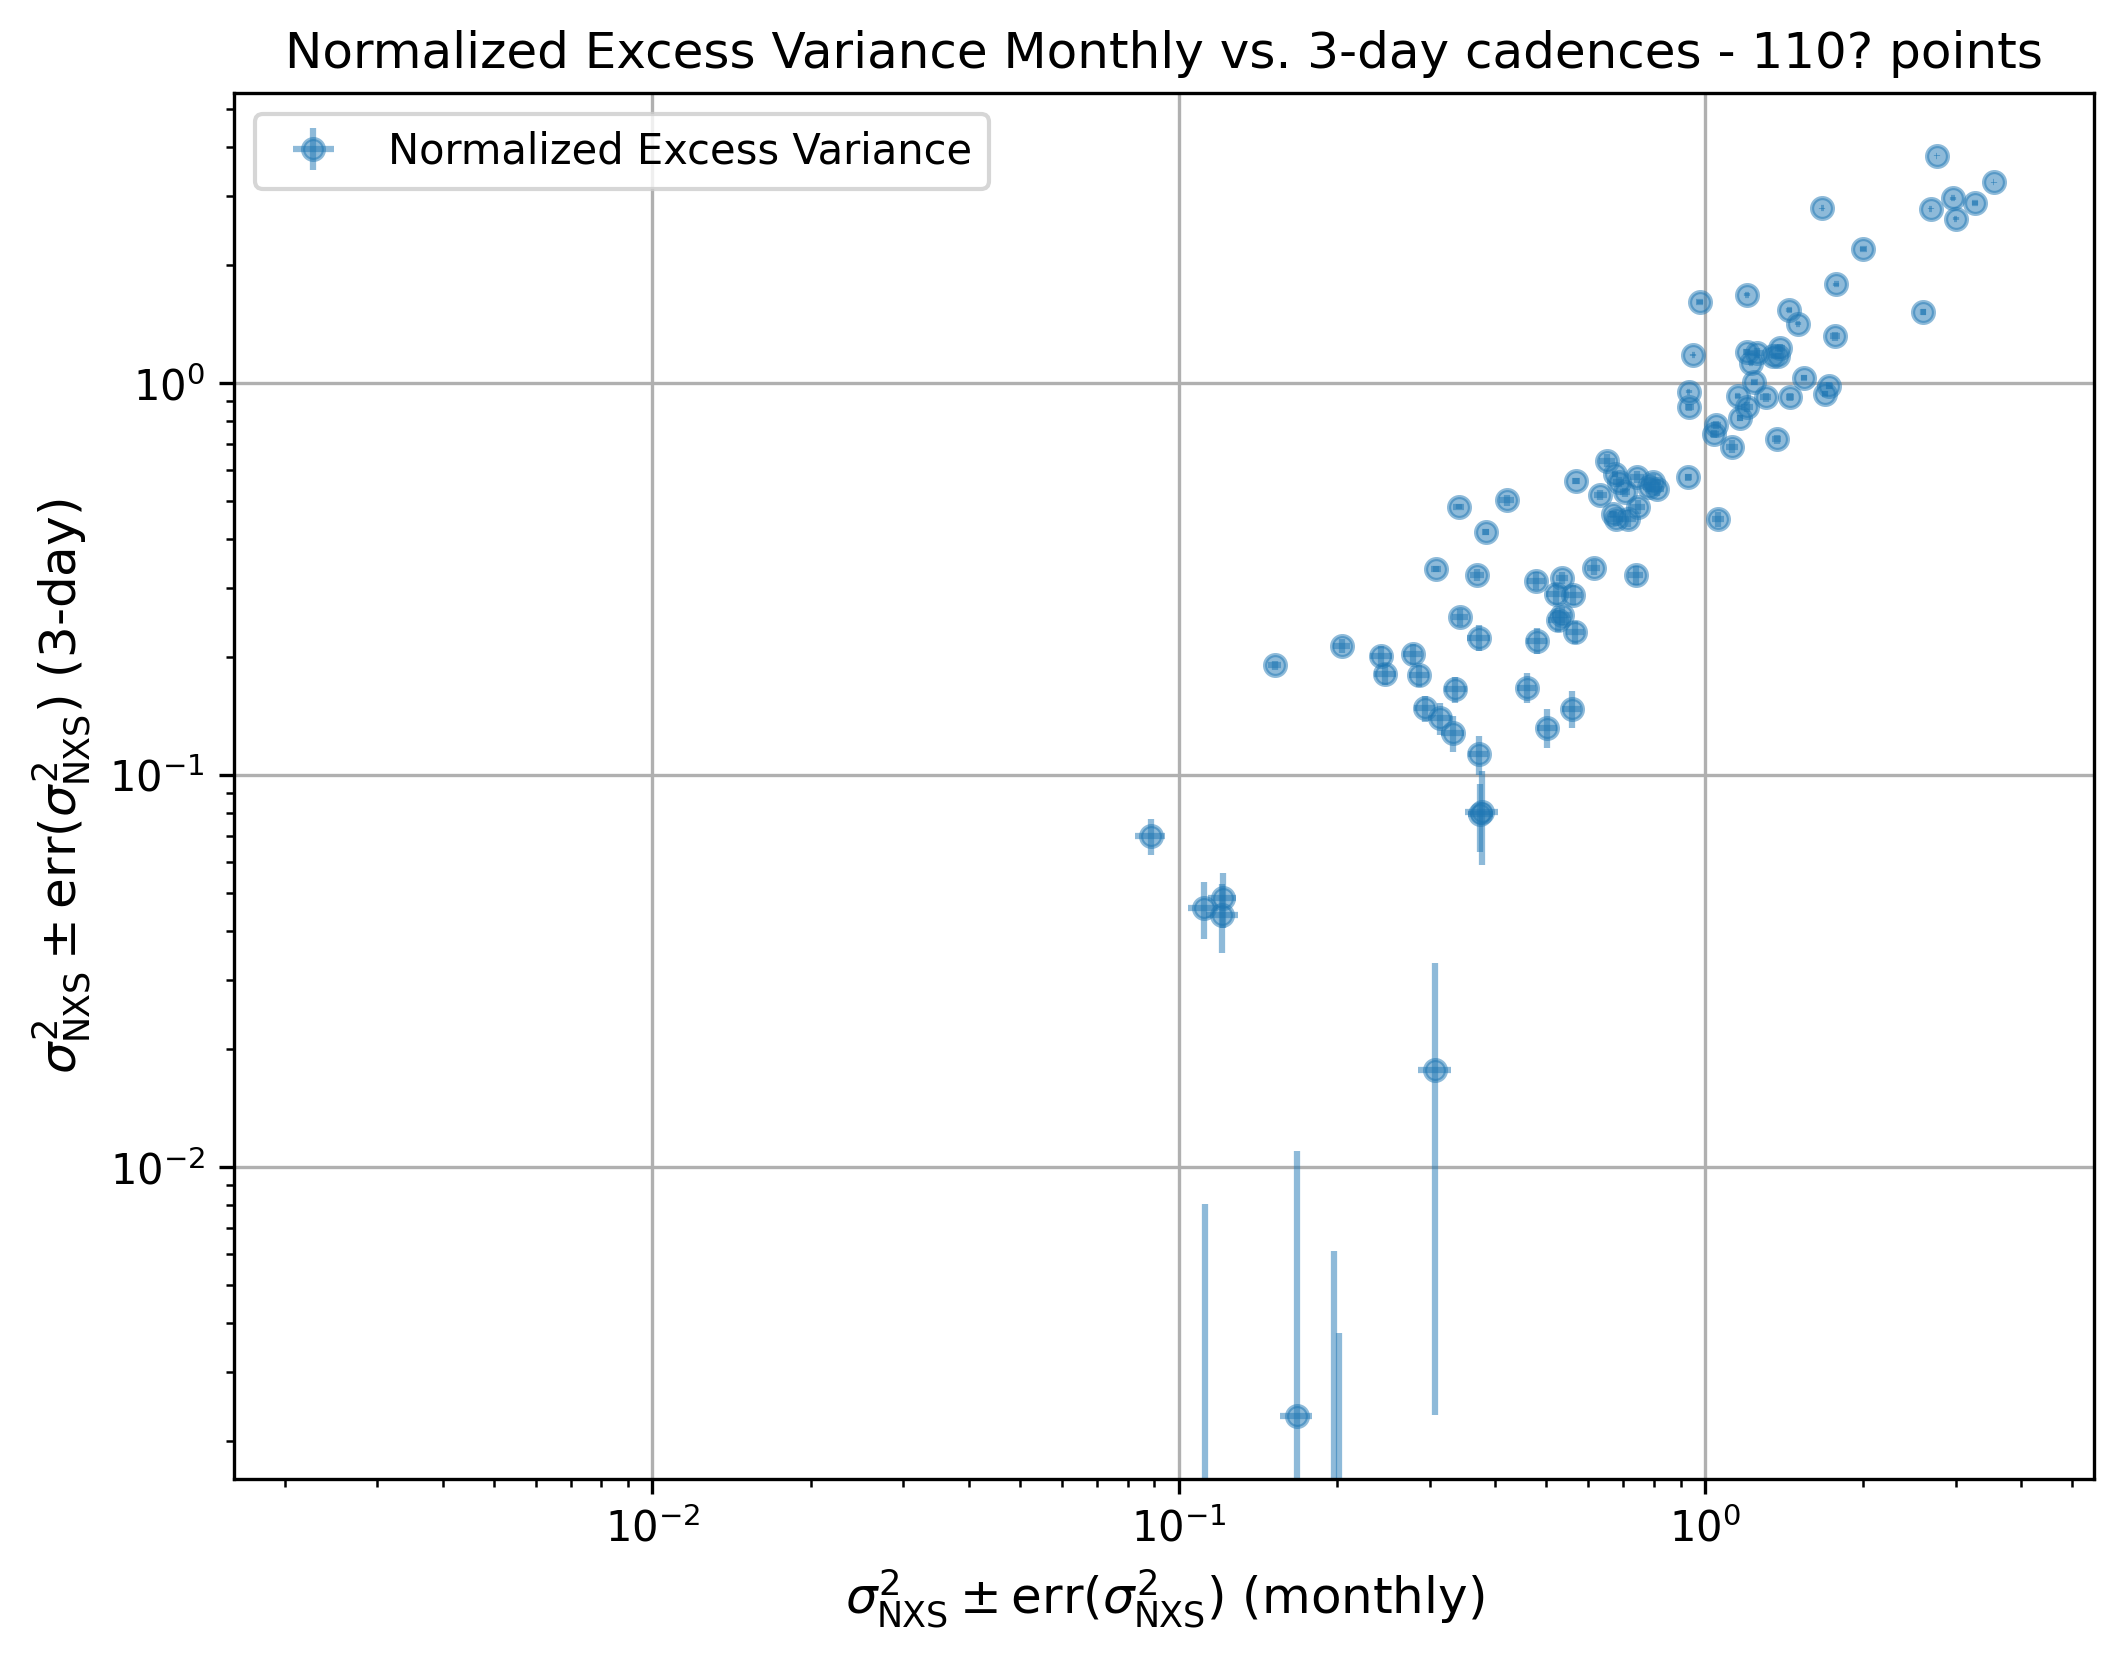

In [41]:
## plot V_NXS(month) +/- eV_NXS(month) versus V_NXS(3-day) +/- eV_NXS(3-day)

plt.figure(figsize=(8,6), dpi=300)

x = selected_table_monthly[selected_table_monthly['Norm_Excess_Var(3_days)'].notna()]
# x = x[x > 0]

plt.errorbar(selected_table_monthly['Norm_Excess_Var(monthly)'], selected_table_monthly['Norm_Excess_Var(3_days)'],
             xerr=selected_table_monthly['Unc_Norm_Excess_Var(monthly)'], yerr=selected_table_monthly['Unc_Norm_Excess_Var(3_days)'],
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x)}? points', fontsize=12)
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.xlim(plt.ylim())
# plt.ylim(plt.xlim())

plt.grid(True)
plt.savefig('plots/selected_monthly_vs_3days_log.png',dpi=300)
plt.show()

In [42]:
## fit

In [43]:
x = selected_table_monthly['Norm_Excess_Var(monthly)']
y = selected_table_monthly['Norm_Excess_Var(3_days)']
x_err = selected_table_monthly['Unc_Norm_Excess_Var(monthly)']
y_err = selected_table_monthly['Unc_Norm_Excess_Var(3_days)']

In [44]:
## filter out non-positive values
valid_indices = (x > 0) & (y > 0)

x = x[valid_indices]
y = y[valid_indices]
x_err = x_err[valid_indices]
y_err = y_err[valid_indices]

In [45]:
len(x)

92

In [46]:
## Log transformation
log_x = np.log(x)
log_y = np.log(y)
log_x_err = x_err / x  # relative error in log scale
log_y_err = y_err / y  # relative error in log scale

Fitted parameter: a = 1.1674165153300395 ± 0.033866422833800425
Fitted parameter: b = 1.0 ± 0.0


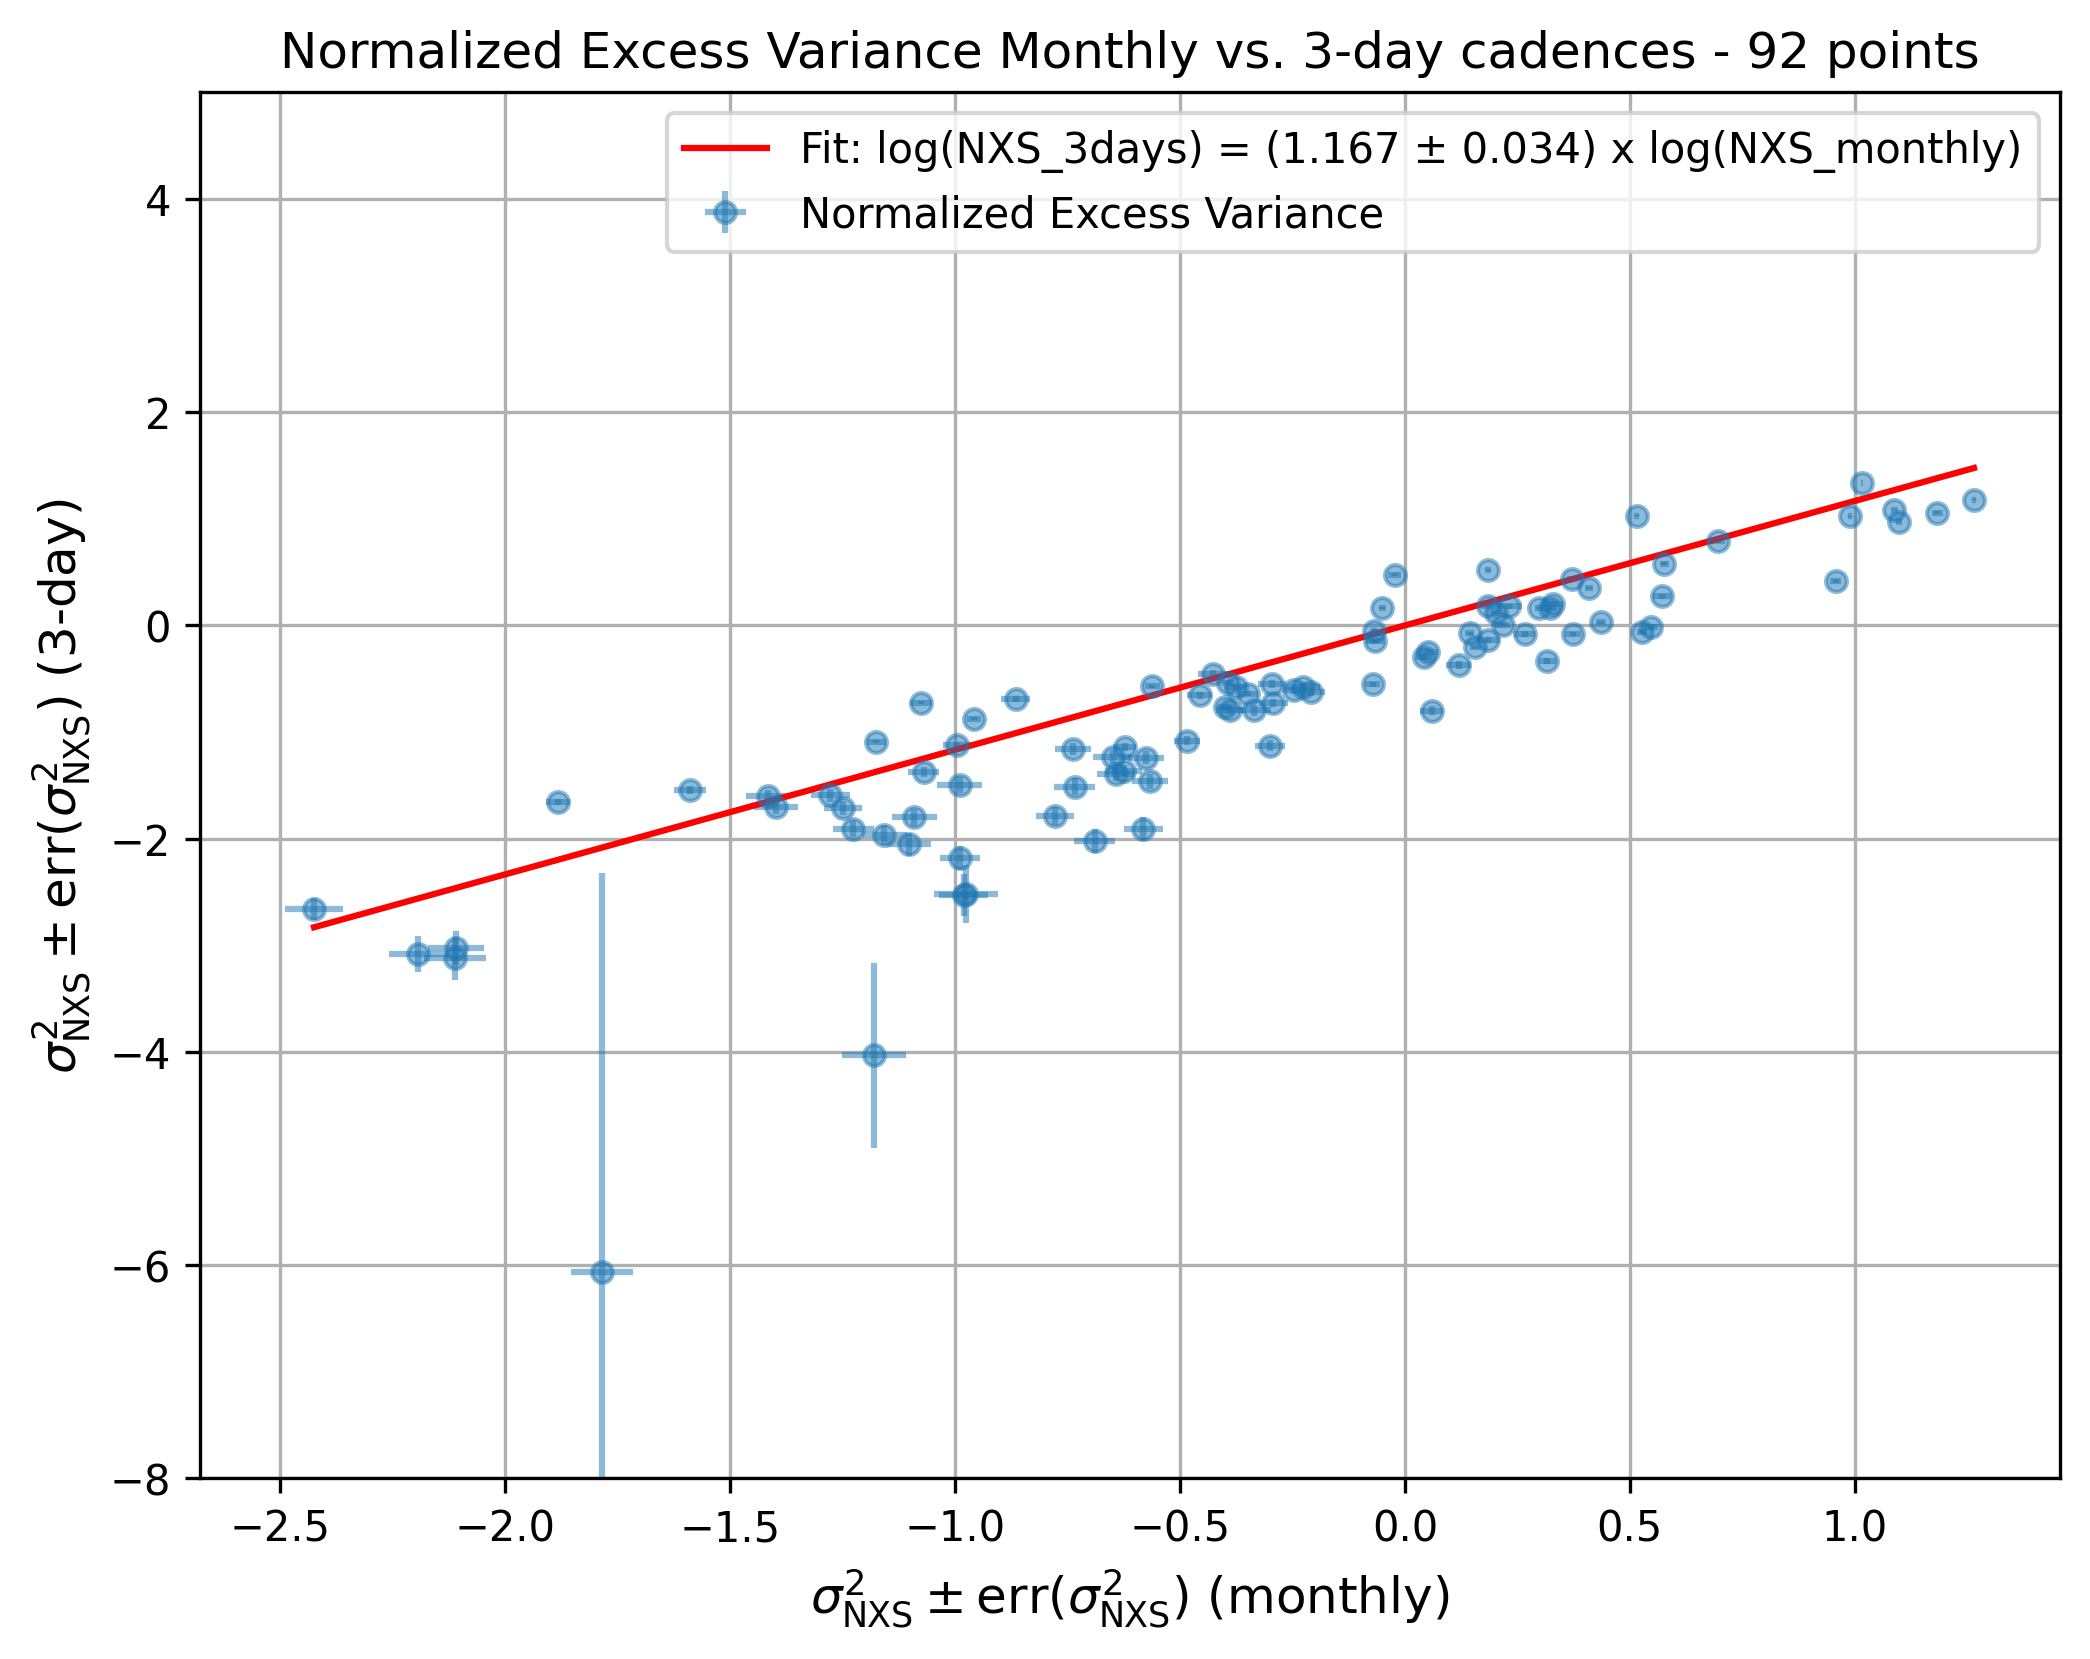

In [47]:
import scipy.odr as odr

def power_law_model(B, x):
    return B[0] * x

## create a model object
power_model = odr.Model(power_law_model)

x_data = log_x
y_data = log_y

x_err = log_x_err 
y_err = log_y_err

## prepare the data for ODR
data = odr.RealData(x_data, y_data, sx=x_err, sy=y_err)

## et initial guess for [a, b]
initial_guess = [1.3, 1.0]

## set up ODR with the model and data
odr_instance = odr.ODR(data, power_model, beta0=initial_guess)

## run the ODR fitting
output = odr_instance.run()

## extract the fitted parameters
a, b = output.beta
a_err, b_err = output.sd_beta

print(f"Fitted parameter: a = {a} ± {a_err}")
print(f"Fitted parameter: b = {b} ± {b_err}")

## plot the data and the fitted model
x_fit = np.linspace(min(x_data), max(x_data), 1000)
y_fit = power_law_model([a, b], x_fit)

plt.figure(figsize=(8,6), dpi=300)

plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err,
             fmt='o', markersize=5, alpha=0.5, label='Normalized Excess Variance')
plt.plot(x_fit, y_fit, label=f'Fit: log(NXS_3days) = ({a:.3f} ± {a_err:.3f}) x log(NXS_monthly)', color='red')

plt.xlabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (monthly)', fontsize=12)
plt.ylabel('$\sigma_{\mathrm{NXS}}^{2} \pm \mathrm{err}(\sigma_{\mathrm{NXS}}^{2})$ (3-day)', fontsize=12)
plt.title(f'Normalized Excess Variance Monthly vs. 3-day cadences - {len(x_data)} points', fontsize=12)
plt.legend()

# plt.xlim(plt.ylim())
plt.ylim(-8,5)

plt.grid(True)
plt.savefig('plots/selected_monthly_vs_3days_log_fit.png',dpi=300)
plt.show()


In [48]:
## add column in our final selected table

selected_table_monthly['Norm_Excess_Var_Extrapolated(3_days)'] = selected_table_monthly['Norm_Excess_Var(monthly)']**a

In [49]:
table_selected_monthly = Table.from_pandas(selected_table_monthly)

In [50]:
table_selected_monthly

Source_Name,SpectrumType,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Spectrum_Flux_Estimated,Bright_Ratio_x,Norm_Excess_Var(3_days),Unc_Norm_Excess_Var(3_days),Frac_Variability(3_days),Unc_Frac_Variability(3_days),Bright_Ratio_y,Norm_Excess_Var(weekly),Unc_Norm_Excess_Var(weekly),Frac_Variability(weekly),Unc_Frac_Variability(weekly),Bright_Ratio,Norm_Excess_Var(monthly),Unc_Norm_Excess_Var(monthly),Frac_Variability(monthly),Unc_Frac_Variability(monthly),Norm_Excess_Var_Extrapolated(3_days)
str12,str11,str5,str3,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
J0001.5+2113,LogParabola,fsrq,ISP,1910.9358,0.9961379,0.21347848,6.391698902983224e-08,--,--,--,--,--,--,--,--,--,--,0.5252525252525253,1.0352761691259023,0.036008389587112145,1.0174852181363139,0.017694797401119615,1.0413024173076335
J0009.3+5030,LogParabola,bll,HSP,204.73532,0.40872404,0.092225395,1.6757091625038766e-08,--,--,--,--,--,0.6666666666666666,-0.04893817678158725,0.016023388099598926,0.0,0.1,0.06060606060606061,0.12064958925756301,0.022296397617964404,0.34734649740218054,0.032095325251183075,0.08467556549947565
J0011.4+0057,LogParabola,fsrq,LSP,231.06699,0.9843933,0.2190029,1.1995542883639901e-08,--,--,--,--,--,--,--,--,--,--,0.96,0.5526671889143475,0.05810301322357782,0.74341589229337,0.039078404044023955,0.5004351989593381
J0022.5+0608,LogParabola,bll,LSP,218.54457,0.45973346,0.10273961,2.687140355246071e-08,--,--,--,--,--,0.6789473684210526,0.028297544228280753,0.01929215989317006,0.1682187392304459,0.05734248152562057,0.05454545454545454,0.22844542646933788,0.02616560462943404,0.47795964941544794,0.027372189955192854,0.17841528703563092
J0030.3-4224,LogParabola,fsrq,LSP,138.98315,0.37055287,0.08603619,2.8809500542311667e-08,--,--,--,--,--,0.8242074927953891,0.4686731478946299,0.03145314687555763,0.6845970697385652,0.022972013952359597,0.15714285714285714,0.6528141552908103,0.03510873103374639,0.8079691549129895,0.021726529298960223,0.6078302037950353
J0030.6-0212,LogParabola,fsrq,LSP,821.95544,0.86677736,0.18714087,3.311832085087464e-08,--,--,--,--,--,--,--,--,--,--,0.5096153846153846,0.5853330356720342,0.032836652064883884,0.7650706082918323,0.021459883381350936,0.5351338987690445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
J2328.3-4036,LogParabola,fsrq,LSP,347.1513,0.6122974,0.13438825,3.410642742585484e-08,--,--,--,--,--,--,--,--,--,--,0.41228070175438597,0.740215801053846,0.0480492853203189,0.860357949375634,0.02792400846367986,0.7038608052156865
J2329.3-4955,LogParabola,FSRQ,LSP,16384.979,1.1942681,0.25476465,1.6372106279411433e-07,0.7750826901874311,0.9406335364023292,0.015472489098264574,0.9698626379041153,0.007976639419629982,0.4490644490644491,1.209843587724593,0.017709147620444045,1.0999289012134343,0.008050132877182984,0.12162162162162163,1.693991950635346,0.01993563571980177,1.301534460026067,0.007658512445149744,1.8502690384963916


In [51]:
df_filtered_4lac_luana_dr3

,Source_Name,SpectrumType,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Spectrum_Flux_Estimated,Bright_Ratio_x,Norm_Excess_Var(3_days),...,Bright_Ratio_y,Norm_Excess_Var(weekly),Unc_Norm_Excess_Var(weekly),Frac_Variability(weekly),Unc_Frac_Variability(weekly),Bright_Ratio,Norm_Excess_Var(monthly),Unc_Norm_Excess_Var(monthly),Frac_Variability(monthly),Unc_Frac_Variability(monthly)
0,J0001.2-0747,PowerLaw,bll,LSP,46.780693,0.406565,0.111870,9.825299e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.846154,-0.100559,0.022187,0.000000,0.100000
1,J0001.5+2113,LogParabola,fsrq,ISP,1910.935791,0.996138,0.213478,6.391699e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.525253,1.035276,0.036008,1.017485,0.017695
2,J0003.3-1928,LogParabola,bcu,LSP,49.879936,0.591879,0.159972,3.715681e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,J0004.3+4614,LogParabola,fsrq,LSP,139.036758,1.016224,0.234237,1.086787e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,J0004.4-4737,PowerLaw,fsrq,LSP,153.286484,0.823498,0.188146,1.070792e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,J2358.0-4601,PowerLaw,bcu,LSP,30.538687,0.477398,0.157409,5.184782e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1425,J2358.3-1021,LogParabola,fsrq,LSP,195.553940,0.668076,0.150551,2.164930e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1426,J2358.3+3830,PowerLaw,bll,NaN,42.173111,0.567347,0.164919,4.248420e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1427,J2359.0+3922,PowerLaw,fsrq,LSP,56.146664,0.779921,0.203910,7.005793e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df_4lac_luana_dr3

,Source_Name,SpectrumType,CLASS,SED_class,Variability_Index,Frac_Variability,Unc_Frac_Variability,Spectrum_Flux_Estimated,Bright_Ratio_x,Norm_Excess_Var(3_days),...,Bright_Ratio_y,Norm_Excess_Var(weekly),Unc_Norm_Excess_Var(weekly),Frac_Variability(weekly),Unc_Frac_Variability(weekly),Bright_Ratio,Norm_Excess_Var(monthly),Unc_Norm_Excess_Var(monthly),Frac_Variability(monthly),Unc_Frac_Variability(monthly)
0,J0001.2+4741,PowerLaw,bcu,ISP,25.313953,0.675882,0.312850,1.993321e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,J0001.2-0747,PowerLaw,bll,LSP,46.780693,0.406565,0.111870,9.825299e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.846154,-0.100559,0.022187,0.000000,0.100000
2,J0001.4-0010,PowerLaw,bll,LSP,9.272764,0.000000,10.000000,8.602307e-10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,J0001.5+2113,LogParabola,fsrq,ISP,1910.935791,0.996138,0.213478,6.391699e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.525253,1.035276,0.036008,1.017485,0.017695
4,J0001.6-4156,PowerLaw,bcu,HSP,26.393343,0.490977,0.175782,1.599132e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,J2359.3+0215,LogParabola,bcu,LSP,16.065315,0.311971,0.625833,1.655760e-10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3810,J2359.3-2049,PowerLaw,bll,LSP,14.043210,0.177217,0.190973,3.021906e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3811,J2359.7-5041,LogParabola,bcu,LSP,7.732565,0.000000,10.000000,1.205902e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3812,J2359.9-3736,PowerLaw,bcu,LSP,8.143241,0.000000,10.000000,2.216054e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
## save table

In [54]:
table_selected_monthly.write('./resulting_catalogs/selected_sources_monthly.fits', format='fits', overwrite=True)
table_selected_monthly.write('./resulting_catalogs/selected_sources_monthly.ecsv', format='ascii.ecsv', overwrite=True)

table_4lac_luana_dr3.write('./resulting_catalogs/df_4lac_luana_dr3.fits', format='fits', overwrite=True)
table_4lac_luana_dr3.write('./resulting_catalogs/df_4lac_luana_dr3.ecsv', format='ascii.ecsv', overwrite=True)

table_filtered_4lac_luana_dr3.write('./resulting_catalogs/df_filtered_4lac_luana_dr3.fits', format='fits', overwrite=True)
table_filtered_4lac_luana_dr3.write('./resulting_catalogs/df_filtered_4lac_luana_dr3.ecsv', format='ascii.ecsv', overwrite=True)

## Tests

In [55]:
source_data = Read_json_file('4FGL+J1104.4+3812.json', '3-days', 'fixed')
source_df = source_data.dataframe
source_dict = source_data.dictionary

In [56]:
source_df[:1202]

,fit_convergence,time_ts,values_ts,dlogl,time_flux,flux,time_flux_upper_limits,flux_upper_limits,flux_error
time_fit_convergence,,,,,,,,,
239716801,0,239716801.0,99.80,0.03980,239716801.0,1.680000e-07,NaN,NaN,4.200000e-08
239976001,0,239976001.0,25.93,0.89000,239976001.0,8.970000e-08,NaN,NaN,3.140000e-08
240235201,0,240235201.0,38.01,0.36800,240235201.0,1.400000e-07,NaN,NaN,4.500000e-08
240494401,0,240494401.0,106.41,0.08270,240494401.0,2.020000e-07,NaN,NaN,4.700000e-08
240753601,0,240753601.0,67.41,1.12000,240753601.0,1.530000e-07,NaN,NaN,4.200000e-08
...,...,...,...,...,...,...,...,...,...
553867201,0,553867201.0,32.31,0.28200,553867201.0,6.980000e-08,NaN,NaN,2.540000e-08
554126401,0,554126401.0,39.73,0.21300,554126401.0,9.440000e-08,NaN,NaN,3.500000e-08
554385601,0,554385601.0,0.00,0.00918,NaN,NaN,554385601.0,2.060000e-07,NaN


In [57]:
filtered_df = filter_outliers(source_df)

In [58]:
filtered_df[:1202]

,fit_convergence,time_ts,values_ts,dlogl,time_flux,flux,time_flux_upper_limits,flux_upper_limits,flux_error
time_fit_convergence,,,,,,,,,
239716801,0,239716801.0,99.80,0.03980,239716801.0,1.680000e-07,NaN,NaN,4.200000e-08
239976001,0,239976001.0,25.93,0.89000,239976001.0,8.970000e-08,NaN,NaN,3.140000e-08
240235201,0,240235201.0,38.01,0.36800,240235201.0,1.400000e-07,NaN,NaN,4.500000e-08
240494401,0,240494401.0,106.41,0.08270,240494401.0,2.020000e-07,NaN,NaN,4.700000e-08
240753601,0,240753601.0,67.41,1.12000,240753601.0,1.530000e-07,NaN,NaN,4.200000e-08
...,...,...,...,...,...,...,...,...,...
553867201,0,553867201.0,32.31,0.28200,553867201.0,6.980000e-08,NaN,NaN,2.540000e-08
554126401,0,554126401.0,39.73,0.21300,554126401.0,9.440000e-08,NaN,NaN,3.500000e-08
554385601,0,554385601.0,0.00,0.00918,NaN,NaN,554385601.0,2.060000e-07,NaN


In [59]:
inputed_df = input_upperL(filtered_df, 'average')

In [60]:
inputed_df[:1202]

,fit_convergence,time_ts,values_ts,dlogl,time_flux,flux,time_flux_upper_limits,flux_upper_limits,flux_error
time_fit_convergence,,,,,,,,,
239716801,0,239716801.0,99.80,0.03980,239716801.0,1.680000e-07,NaN,NaN,4.200000e-08
239976001,0,239976001.0,25.93,0.89000,239976001.0,8.970000e-08,NaN,NaN,3.140000e-08
240235201,0,240235201.0,38.01,0.36800,240235201.0,1.400000e-07,NaN,NaN,4.500000e-08
240494401,0,240494401.0,106.41,0.08270,240494401.0,2.020000e-07,NaN,NaN,4.700000e-08
240753601,0,240753601.0,67.41,1.12000,240753601.0,1.530000e-07,NaN,NaN,4.200000e-08
...,...,...,...,...,...,...,...,...,...
553867201,0,553867201.0,32.31,0.28200,553867201.0,6.980000e-08,NaN,NaN,2.540000e-08
554126401,0,554126401.0,39.73,0.21300,554126401.0,9.440000e-08,NaN,NaN,3.500000e-08
554385601,0,554385601.0,0.00,0.00918,NaN,1.783722e-07,554385601.0,NaN,2.060000e-07


In [61]:
source_dict

{'name': 'J1104.4+3812',
 'time_flux': array([2.39716801e+08, 2.39976001e+08, 2.40235201e+08, ...,
        7.28308801e+08, 7.28568001e+08, 7.28827201e+08]),
 'flux': array([1.68e-07, 8.97e-08, 1.40e-07, ..., 1.99e-07, 3.03e-07, 2.92e-07]),
 'time_flux_upper_limits': array([4.29192001e+08, 4.91918401e+08, 4.92177601e+08, 5.42980801e+08,
        5.44536001e+08, 5.44795201e+08, 5.45054401e+08, 5.54385601e+08,
        5.56200001e+08, 5.57755201e+08, 5.58273601e+08, 5.70715201e+08,
        5.70974401e+08, 5.71233601e+08, 5.71492801e+08, 5.71752001e+08,
        5.89377601e+08, 6.02596801e+08, 6.02856001e+08, 6.03633601e+08,
        6.34737601e+08, 6.34996801e+08, 6.35515201e+08, 6.52881601e+08,
        6.53140801e+08, 6.66878401e+08, 6.67137601e+08, 6.85022401e+08,
        6.98760001e+08, 6.99019201e+08, 6.99278401e+08, 7.16904001e+08]),
 'flux_upper_limits': array([ 6.48e-08,  3.40e-07, -1.00e+00,  1.46e-06, -1.00e+00,  6.95e-06,
         3.04e-07,  2.06e-07, -1.00e+00,  3.77e-07, -1.00e+00